## Simulate non-isoplanatic imaging for LOW at 100MHz.

### A set of model components are drawn from GLEAM. An ionospheric screen model is used to calculate the pierce points of the two stations in an interferometer for a given component. The model visibilities are calculated directly, and screen phase applied to obtain the corrupted visibility.

In [1]:
%matplotlib inline

import sys

from data_models.parameters import arl_path

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel

from matplotlib import pyplot as plt
from matplotlib import pylab as pylab

from data_models.memory_data_models import SkyModel
from data_models.polarisation import PolarisationFrame
from data_models.data_model_helpers import export_blockvisibility_to_hdf5, export_skymodel_to_hdf5, \
    export_skycomponent_to_hdf5

from processing_library.util.coordinate_support import simulate_point, skycoord_to_lmn
from processing_library.image.operations import copy_image

from wrappers.serial.imaging.primary_beams import create_low_test_beam
from wrappers.serial.skycomponent.operations import apply_beam_to_skycomponent, remove_neighbouring_components
from wrappers.serial.imaging.base import create_image_from_visibility, advise_wide_field
from wrappers.serial.image.operations import import_image_from_fits, export_image_to_fits
from wrappers.serial.visibility.coalesce import convert_blockvisibility_to_visibility
from wrappers.serial.skycomponent.operations import insert_skycomponent
from wrappers.serial.image.operations import smooth_image, show_components
from wrappers.serial.calibration.calibration_control import calibrate_function, create_calibration_controls
from wrappers.serial.skycomponent.operations import find_skycomponents
from wrappers.serial.visibility.base import create_blockvisibility, copy_visibility
from wrappers.serial.image.operations import show_image, qa_image
from wrappers.serial.simulation.testing_support import create_named_configuration, \
    create_low_test_skycomponents_from_gleam, create_unittest_components
from wrappers.serial.skycomponent.operations import filter_skycomponents_by_flux, image_voronoi_iter, \
    select_neighbouring_components, partition_skycomponent_neighbours, voronoi_decomposition


from data_models.data_model_helpers import export_blockvisibility_to_hdf5, export_skymodel_to_hdf5, export_gaintable_to_hdf5


In [2]:
import logging
def init_logging():
    logging.basicConfig(filename='results/low-sims-mpc.log',
                        filemode='a',
                        format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG)

init_logging()
log = logging.getLogger()
    
def lprint(*args):
    log.info(*args)
    print(*args)

In [3]:
pylab.rcParams['figure.figsize'] = (14.0, 14.0)
pylab.rcParams['image.cmap'] = 'rainbow'

### Set up the observation: 10 minutes at transit, with 10s integration.

In [4]:
nfreqwin = 1
ntimes = 61
rmax = 550.0
dec = -40.0 * u.deg
frequency = numpy.linspace(1e8, 1.3e8, nfreqwin)
if nfreqwin > 1:
    channel_bandwidth = numpy.array(nfreqwin * [frequency[1] - frequency[0]])
else:
    channel_bandwidth = [0.3e8]
times = numpy.linspace(-300, 300.0, ntimes) * numpy.pi / (3600.0 * 12.0)

phasecentre = SkyCoord(ra=+0.0 * u.deg, dec=dec, frame='icrs', equinox='J2000')
lowcore = create_named_configuration('LOWBD2', rmax=rmax)

blockvis = create_blockvisibility(
    lowcore,
    times,
    frequency=frequency,
    channel_bandwidth=channel_bandwidth,
    weight=1.0,
    phasecentre=phasecentre,
    polarisation_frame=PolarisationFrame("stokesI"),
    zerow=True)

### Find sampling, image size, etc

In [5]:
wprojection_planes = 1
vis = convert_blockvisibility_to_visibility(blockvis)
advice = advise_wide_field(vis, guard_band_image=2.0, delA=0.02)

cellsize = advice['cellsize']
vis_slices = advice['vis_slices']
npixel = advice['npixels2']

In [12]:
print(cellsize)

0.000982891632582028


### Generate the model from the GLEAM catalog, including application of the primary beam.

Number of bright components 111


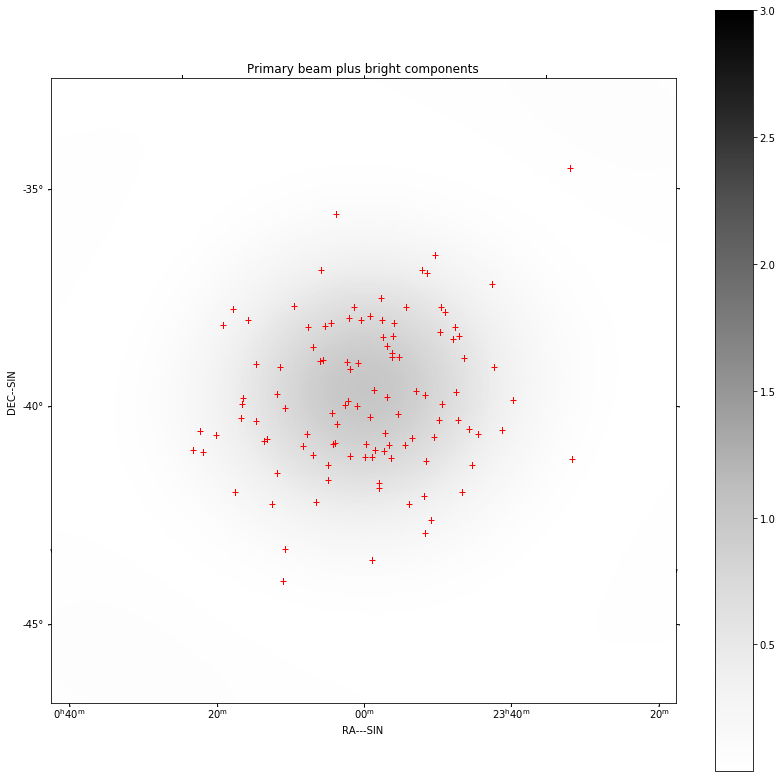

In [6]:
flux_limit = 0.05
beam = create_image_from_visibility(
    blockvis,
    npixel=npixel,
    frequency=frequency,
    nchan=nfreqwin,
    cellsize=cellsize,
    phasecentre=phasecentre)
beam = create_low_test_beam(beam)

original_gleam_components = create_low_test_skycomponents_from_gleam(
    flux_limit=flux_limit,
    phasecentre=phasecentre,
    frequency=frequency,
    polarisation_frame=PolarisationFrame('stokesI'),
    radius=0.2)

pb_gleam_components = apply_beam_to_skycomponent(original_gleam_components,
                                                 beam)
bright_components = filter_skycomponents_by_flux(
    pb_gleam_components, flux_min=0.3)
all_components = filter_skycomponents_by_flux(
    pb_gleam_components, flux_min=flux_limit)

show_image(
    beam,
    components=bright_components,
    cm='Greys',
    title='Primary beam plus bright components',
    vmax=3.0)

lprint("Number of bright components %d" % len(bright_components))

Number of bright components 58


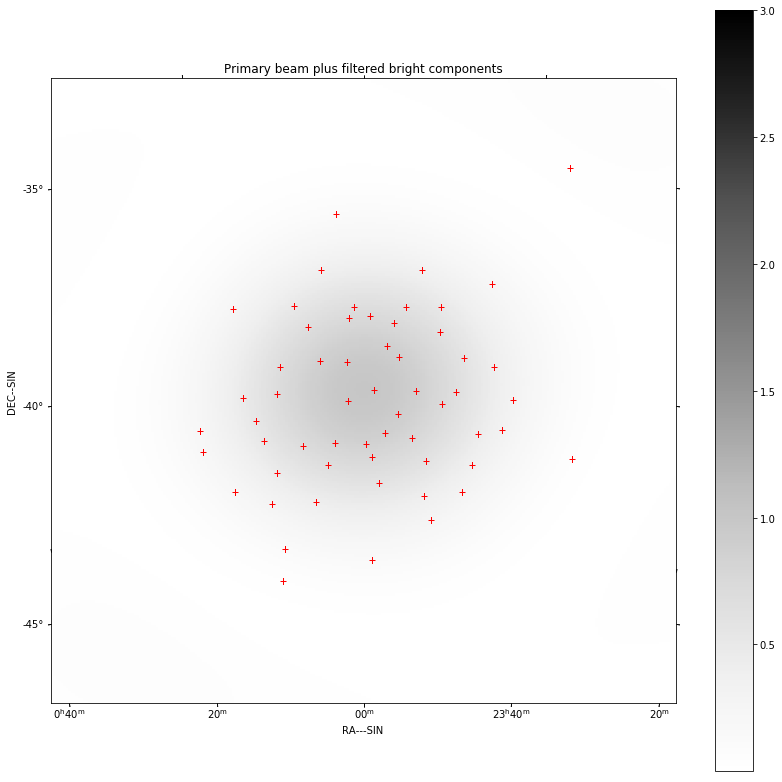

In [7]:
idx, filtered_bright_components = remove_neighbouring_components(bright_components, 0.01)
show_image(
    beam,
    components=filtered_bright_components,
    cm='Greys',
    title='Primary beam plus filtered bright components',
    vmax=3.0)

lprint("Number of bright components %d" % len(filtered_bright_components))

Number of components 525


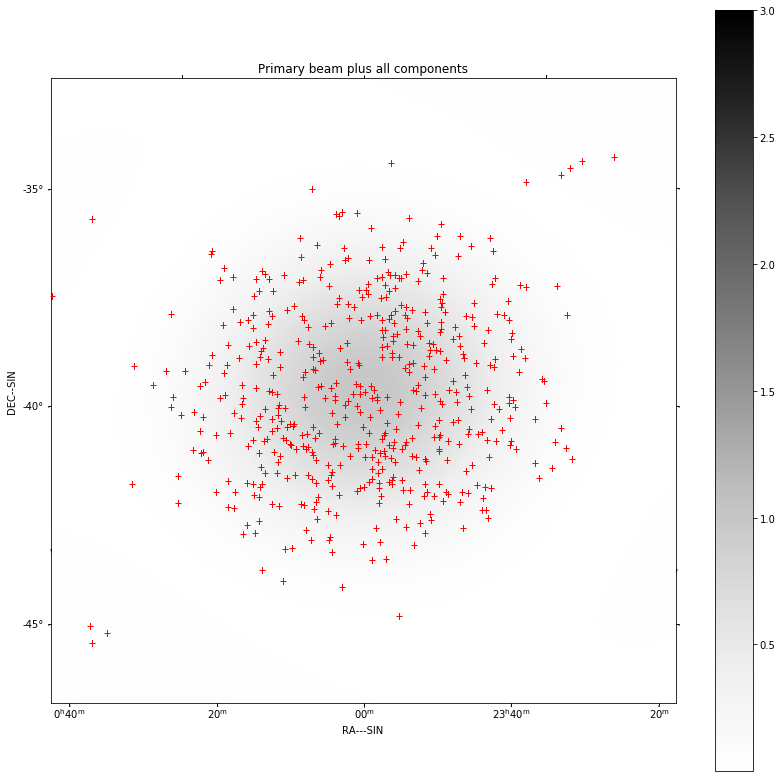

In [8]:
show_image(
    beam,
    components=all_components,
    cm='Greys',
    title='Primary beam plus all components',
vmax=3.0)

lprint("Number of components %d" % len(all_components))

### Now show all components with color denoting the nearest bright component, and an image with each pixel filled with the index of the nearest bright component

Number of (bright and weak) components 525


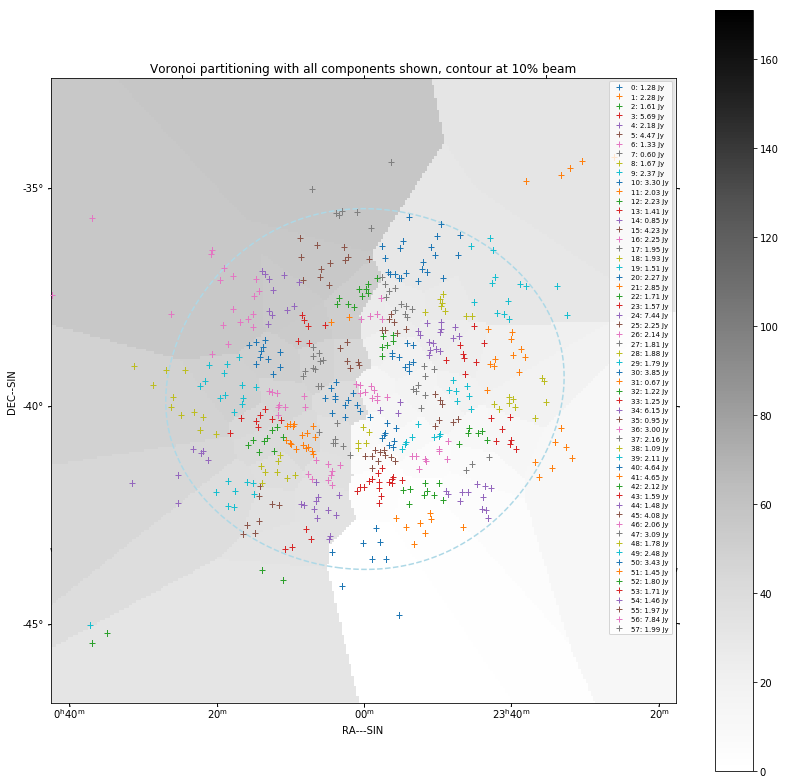

In [9]:
vor, vor_array = voronoi_decomposition(beam, filtered_bright_components)
vor_image = copy_image(beam)
vor_image.data[...] = vor_array

show_image(
    vor_image,
    cm='Greys',
    title='Voronoi partitioning with all components shown, contour at 10% beam',
    vmax = 3 * numpy.max(vor_array))

comps_lists = partition_skycomponent_neighbours(all_components, filtered_bright_components) 

for comp_id, comps in enumerate(comps_lists):    
    flux = numpy.sum([c.flux[0,0] for c in comps])
    directions = SkyCoord([u.rad * c.direction.ra.rad for c in comps],
                          [u.rad * c.direction.dec.rad for c in comps])
    x, y = skycoord_to_pixel(directions, beam.wcs, 0, 'wcs')
    plt.plot(x, y, '+', label='%d: %.2f Jy' % (comp_id, flux))
    
plt.rc('legend',**{'fontsize':7})
plt.legend()

lprint("Number of (bright and weak) components %d" % len(all_components))

plt.contour(beam.data[0,0], levels=[0.1], colors='lightblue', linestyles='dashed')



Number of (bright and weak) components 525


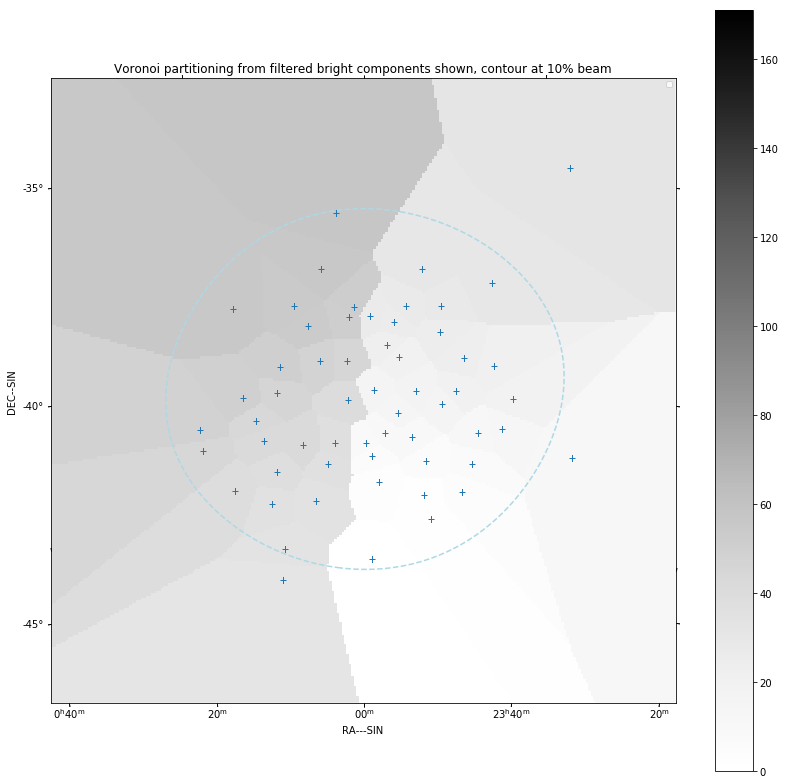

In [10]:
show_image(
    vor_image,
    cm='Greys',
    title='Voronoi partitioning from filtered bright components shown, contour at 10% beam',
    vmax = 3 * numpy.max(vor_array))

comps= filtered_bright_components
directions = SkyCoord([u.rad * c.direction.ra.rad for c in comps],
                        [u.rad * c.direction.dec.rad for c in comps])
x, y = skycoord_to_pixel(directions, beam.wcs, 0, 'wcs')
plt.plot(x, y, '+')
    
plt.legend()

lprint("Number of (bright and weak) components %d" % len(all_components))

plt.contour(beam.data[0,0], levels=[0.1], colors='lightblue', linestyles='dashed')

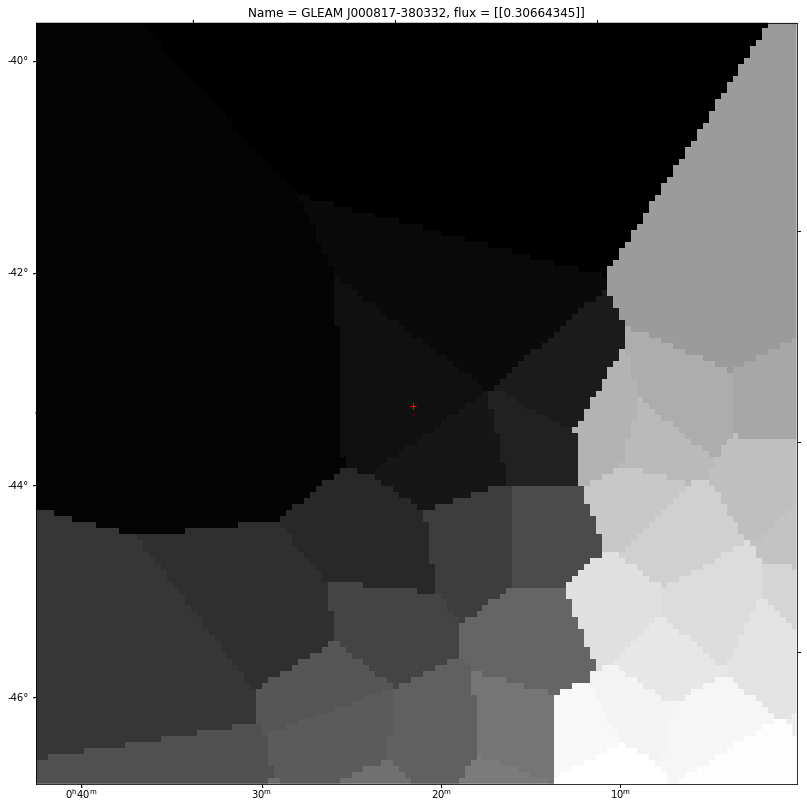

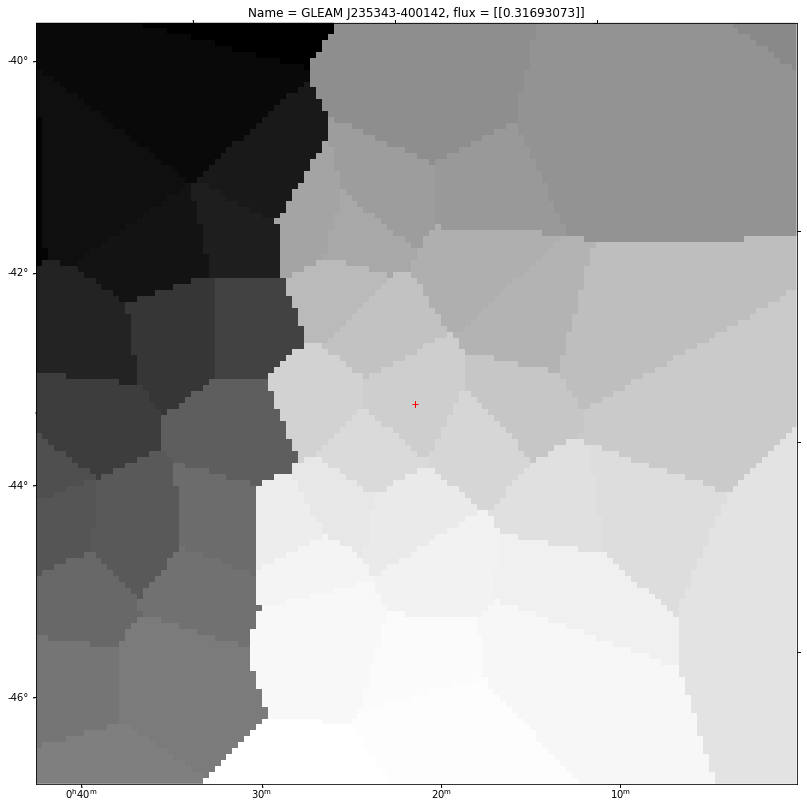

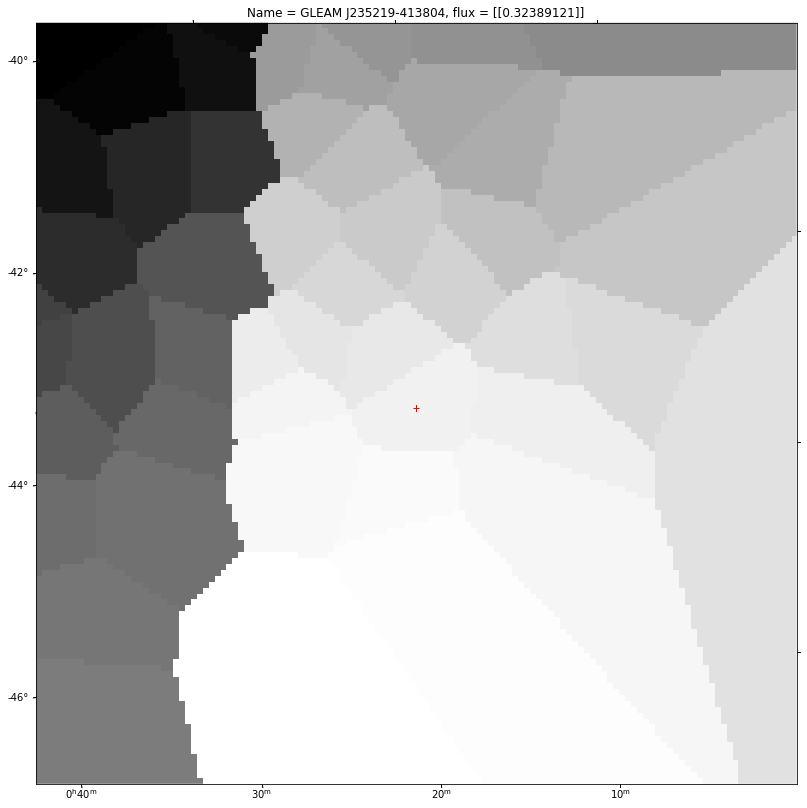

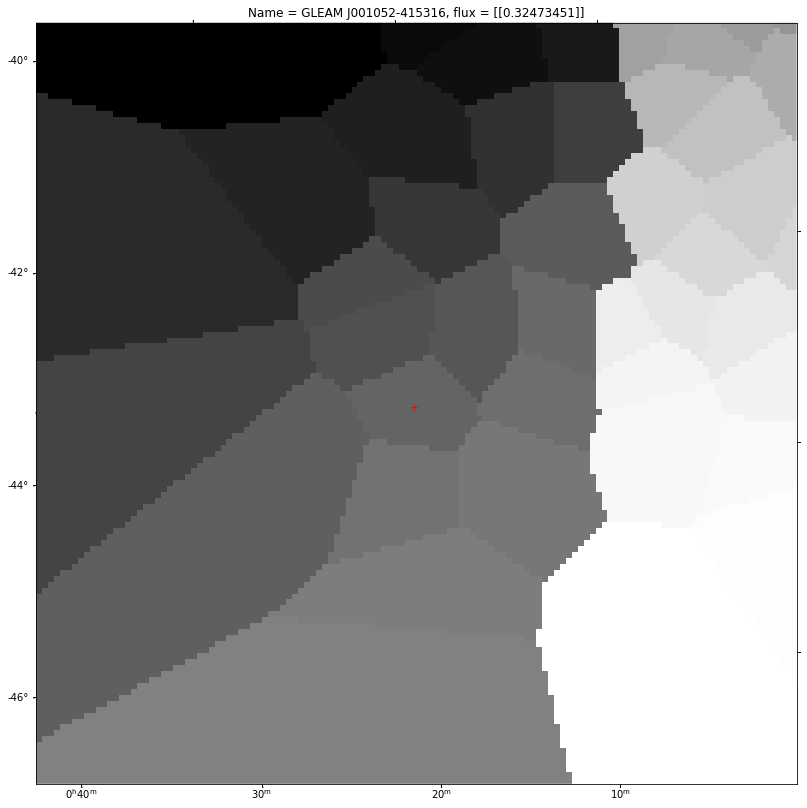

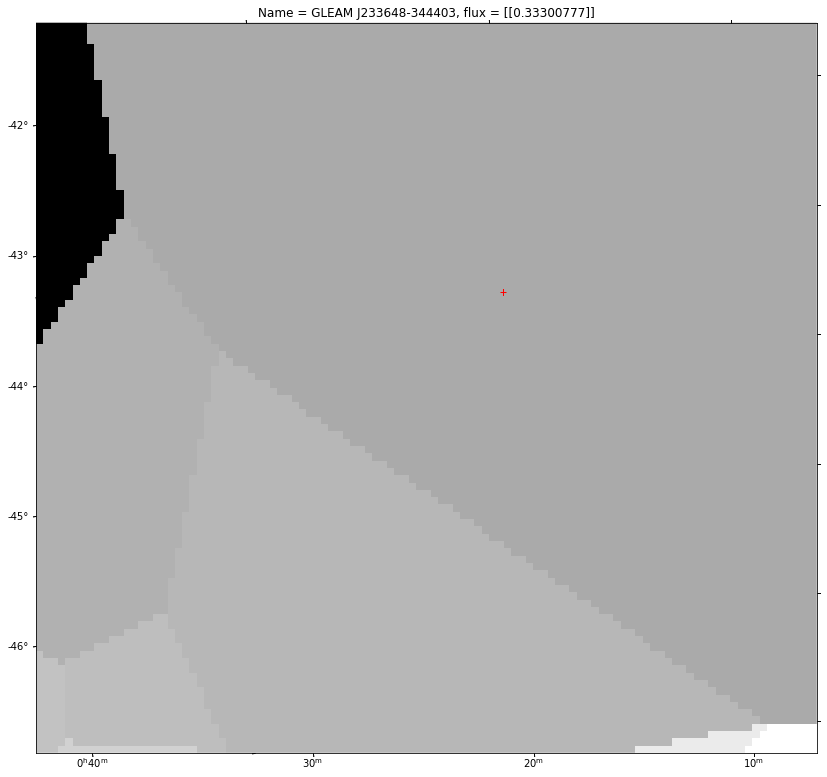

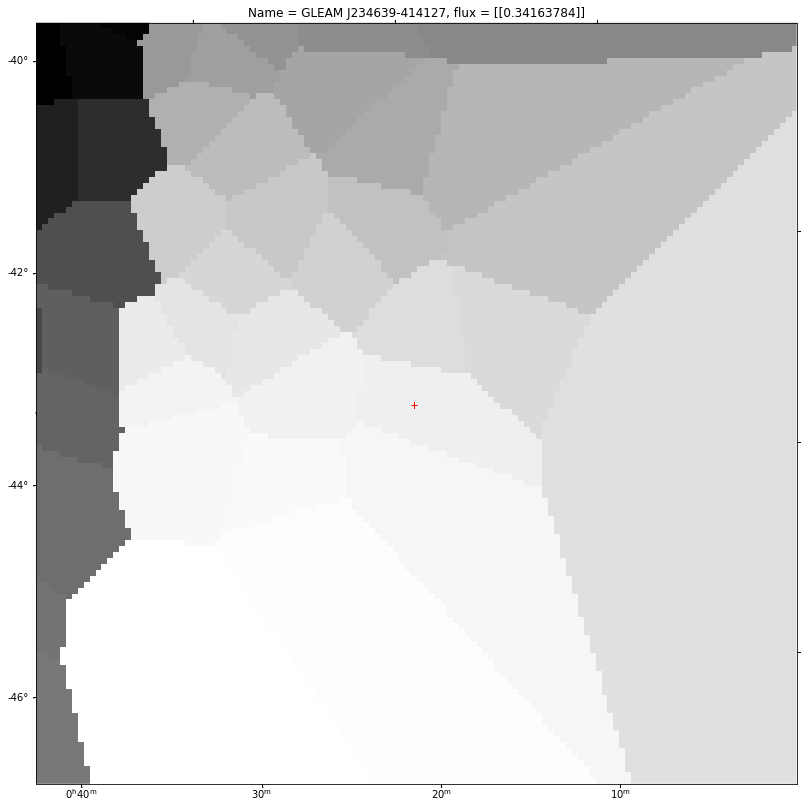

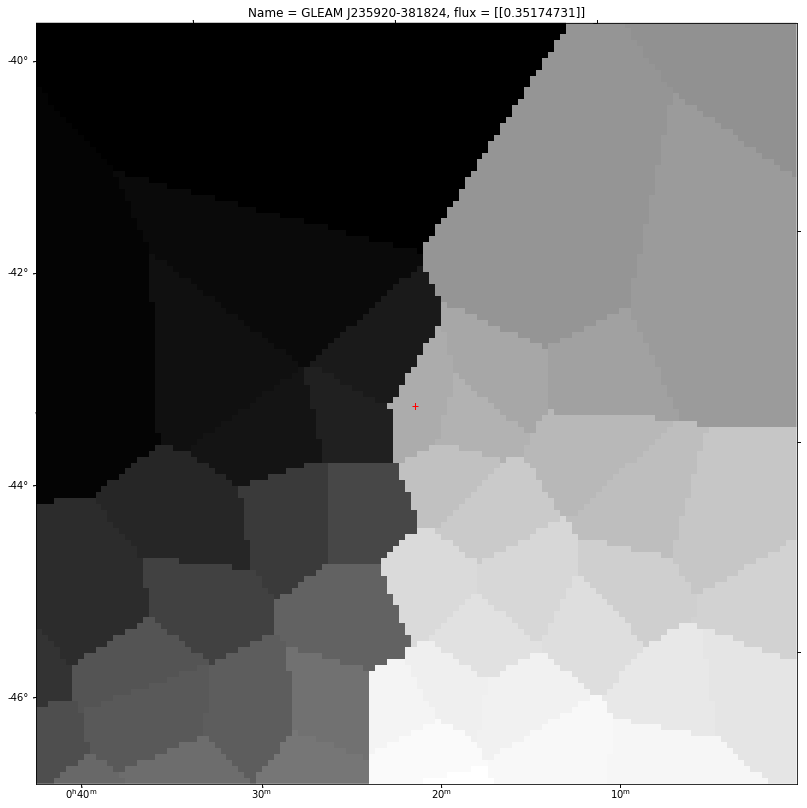

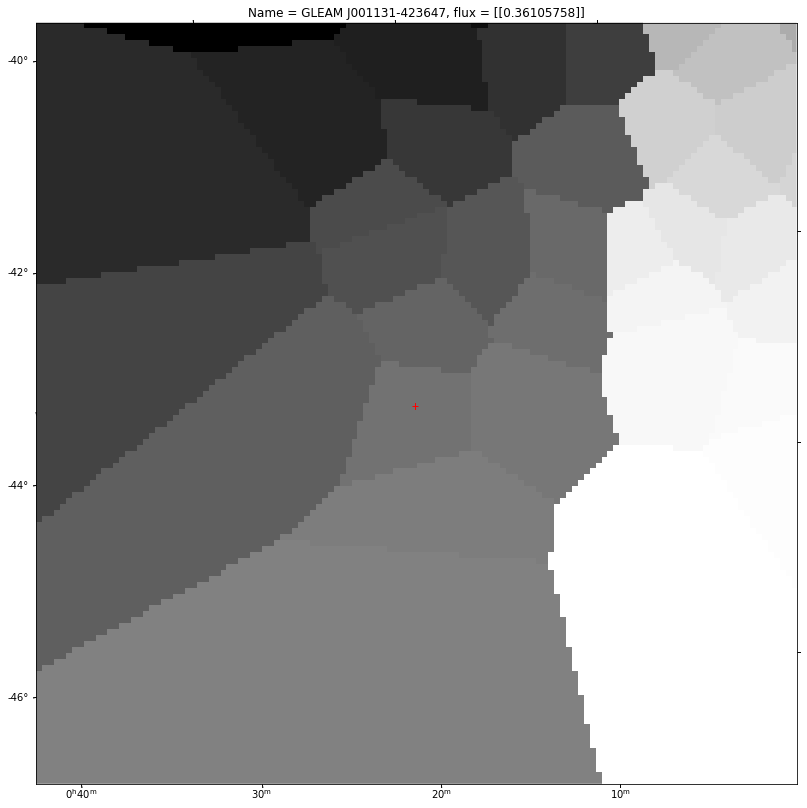

/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))


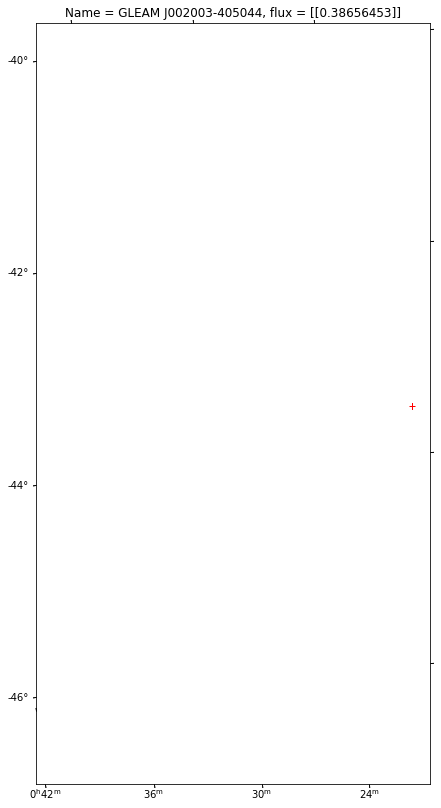

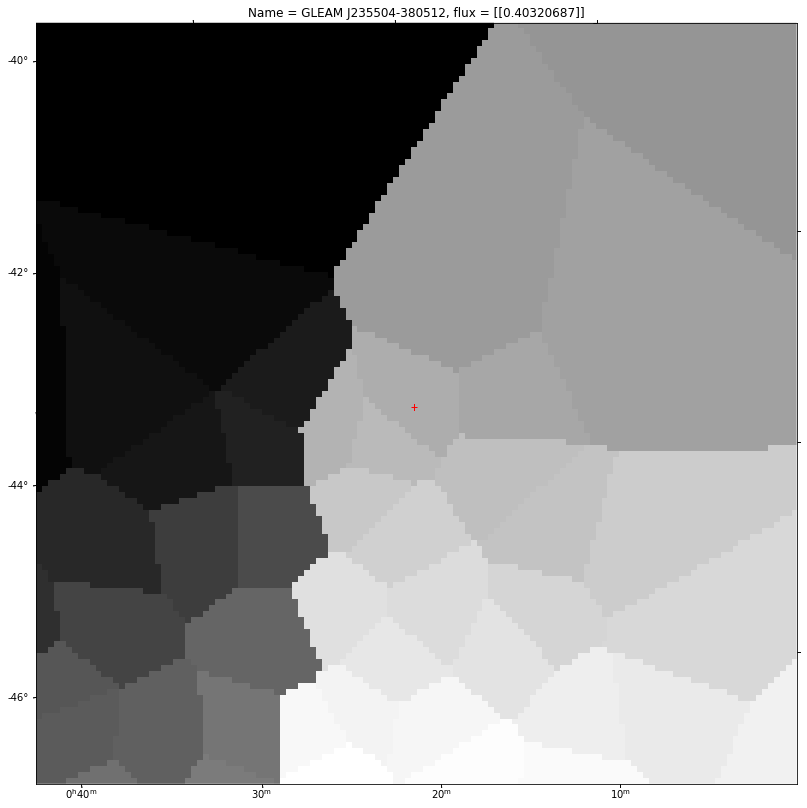

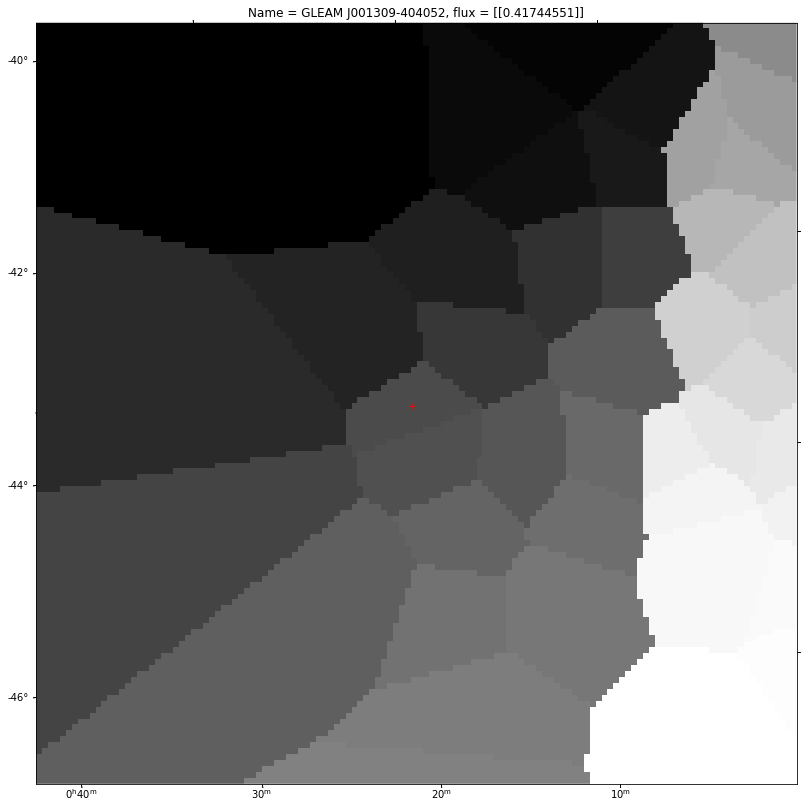

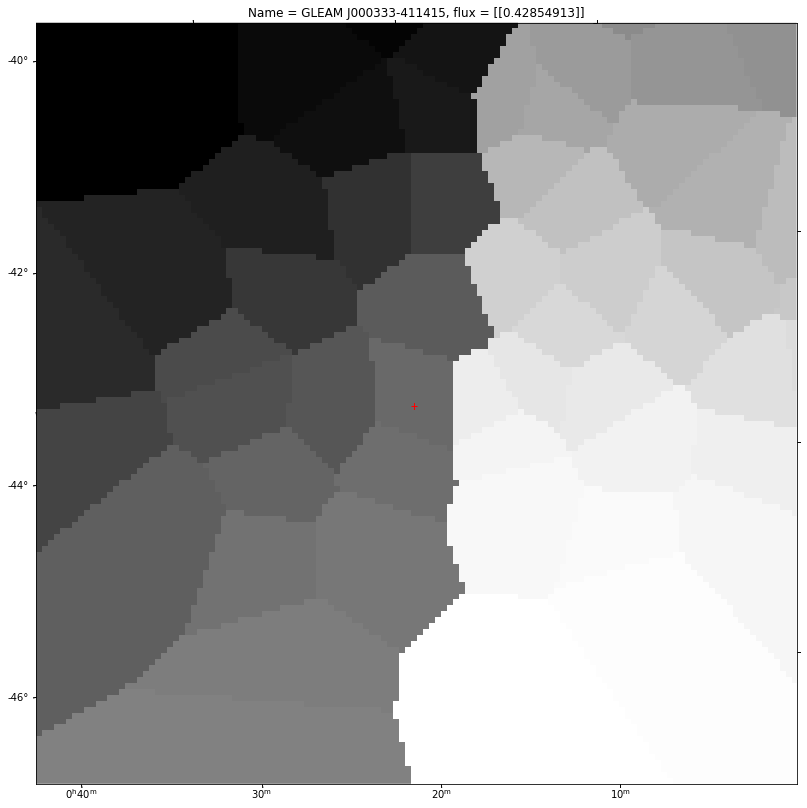

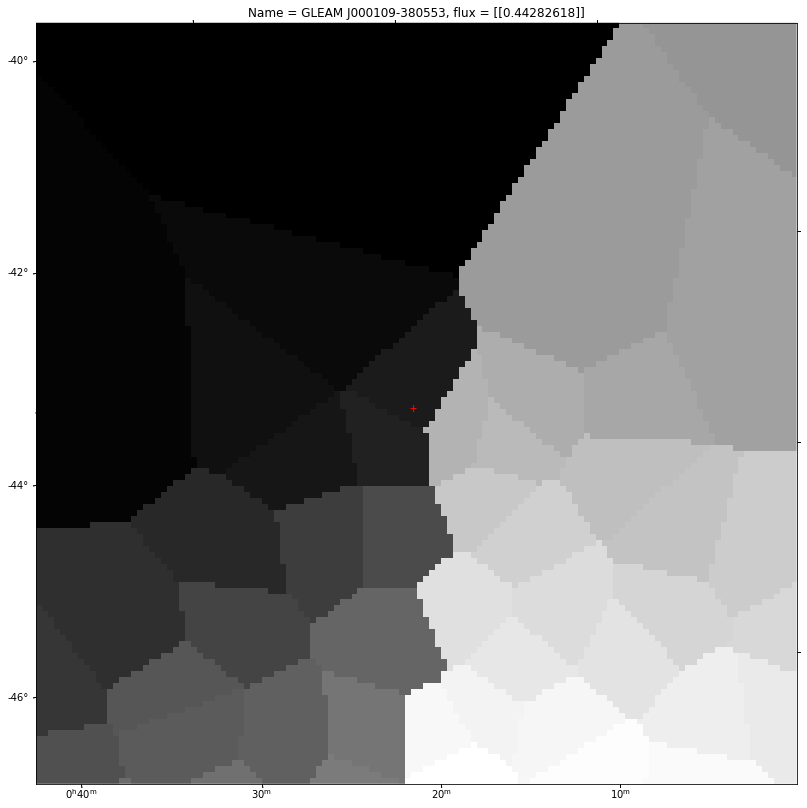

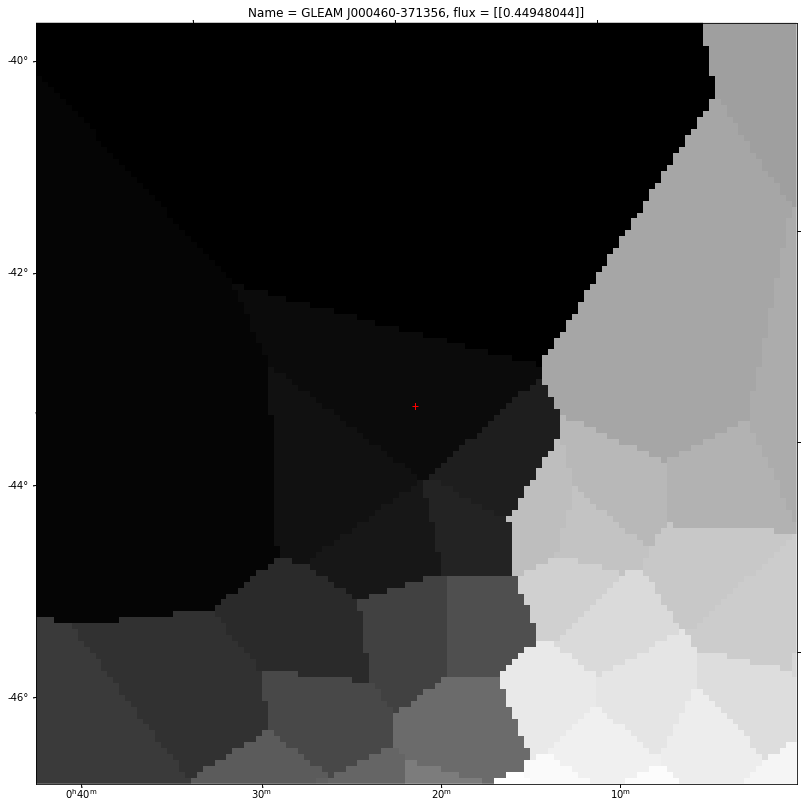

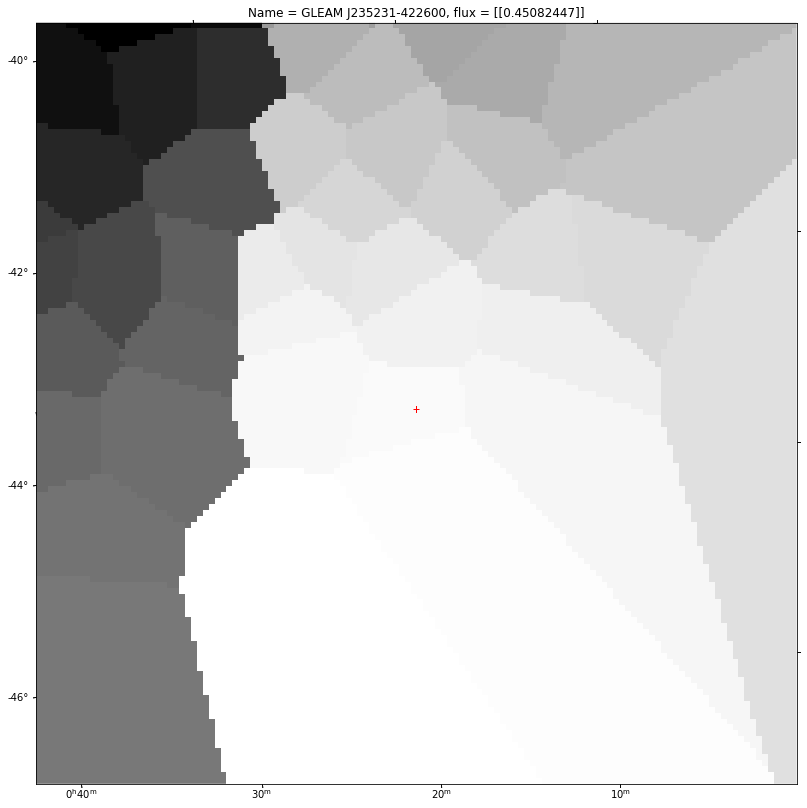

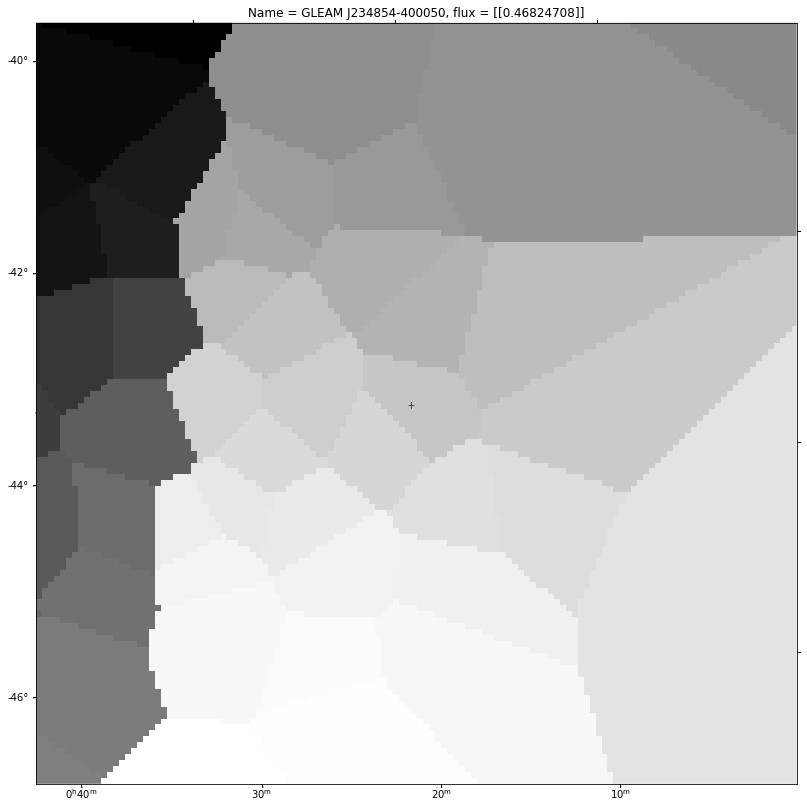

/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


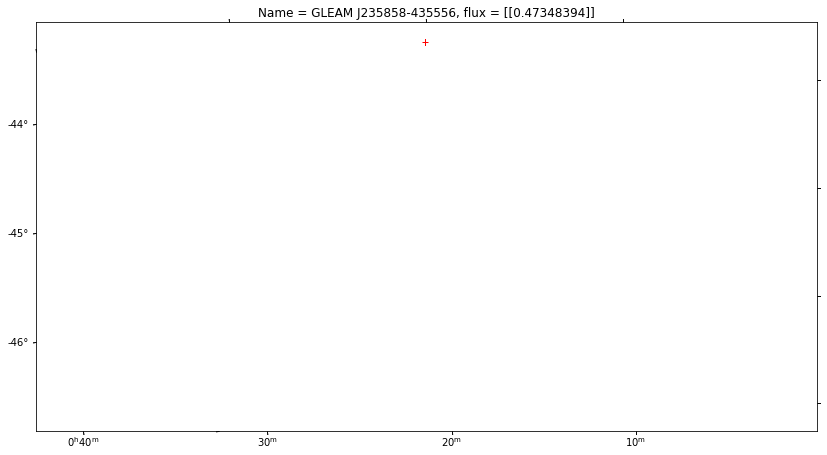

/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))


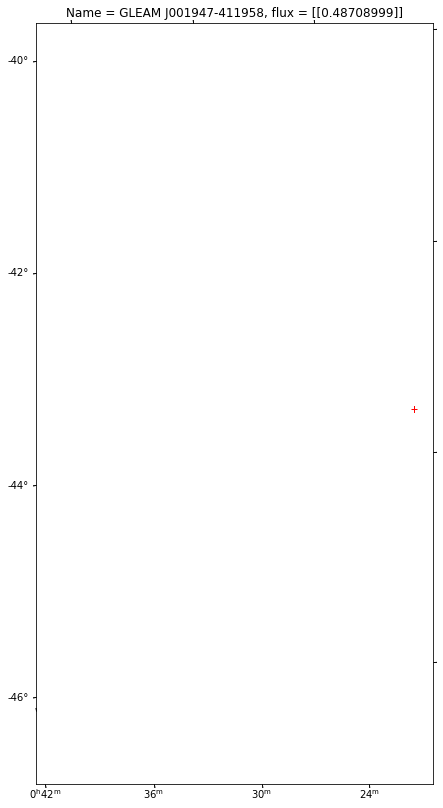

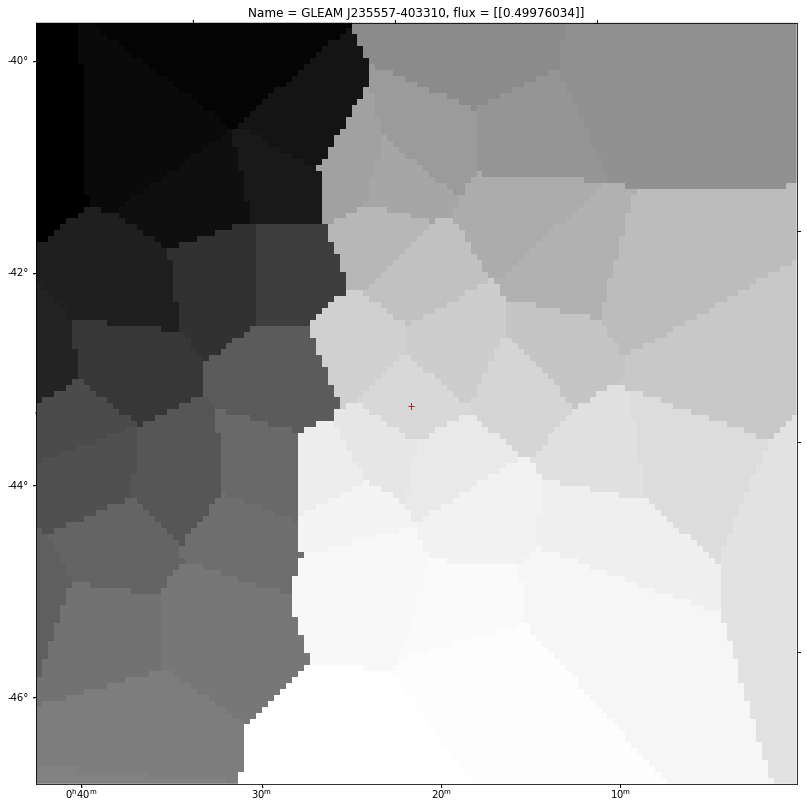

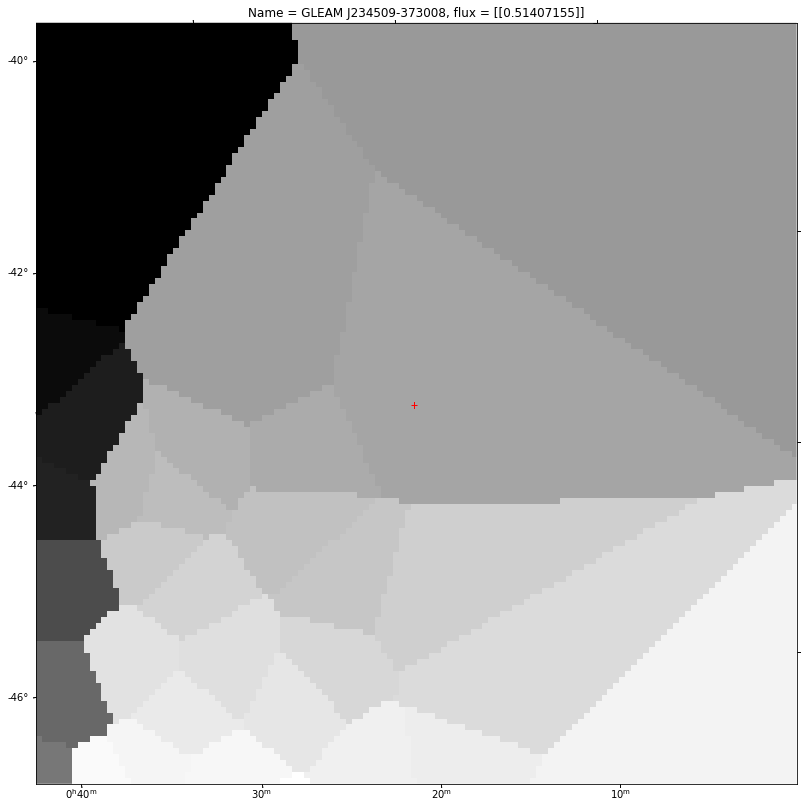

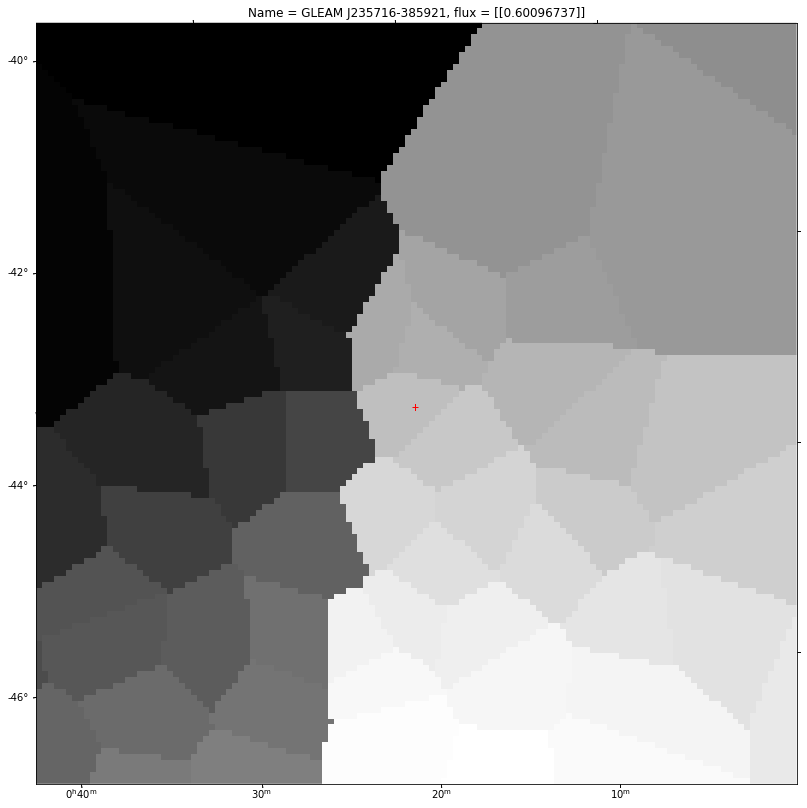

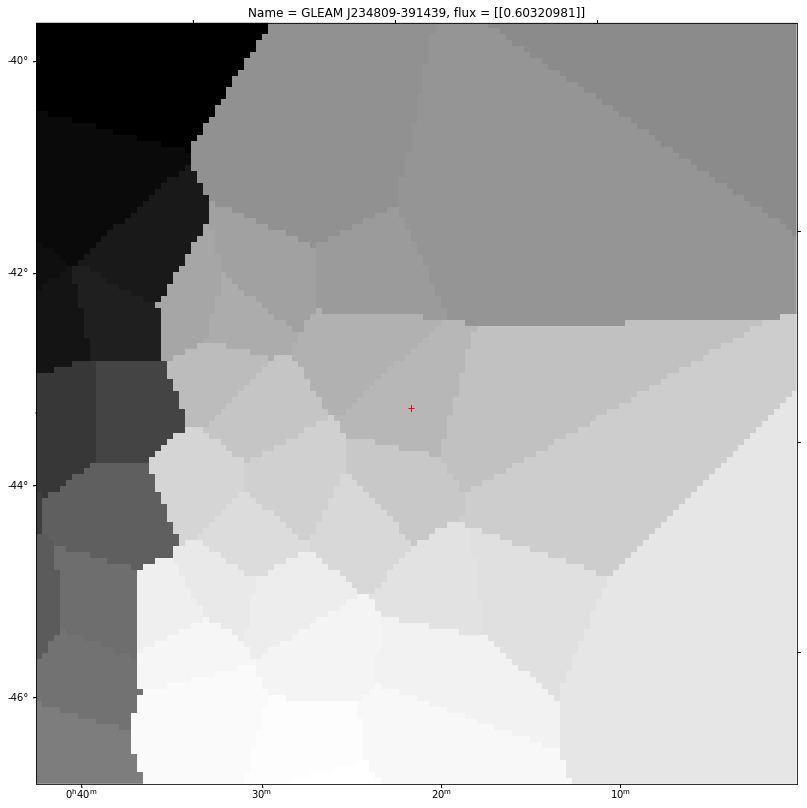

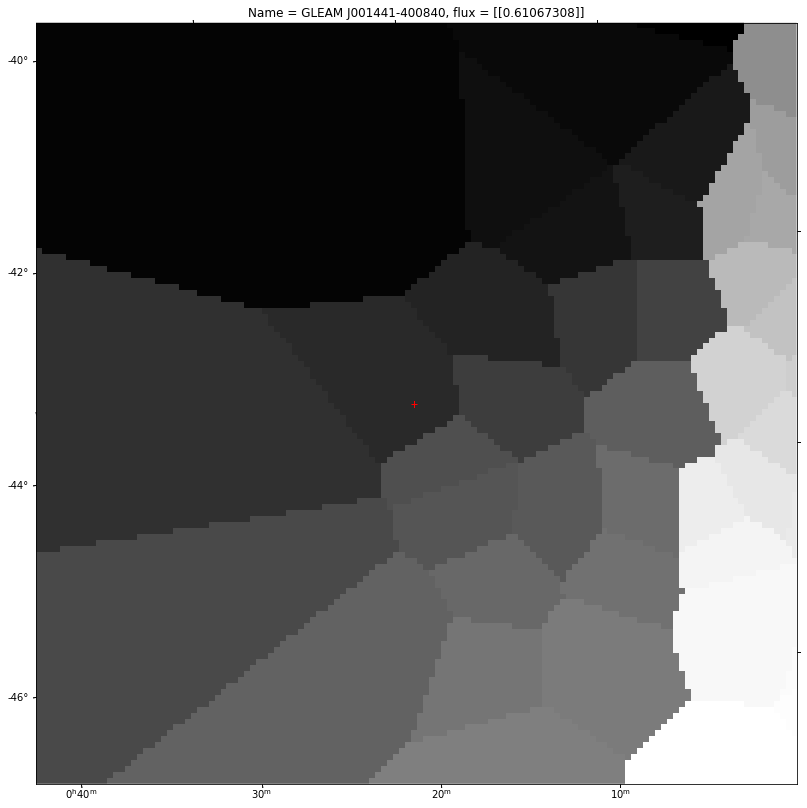

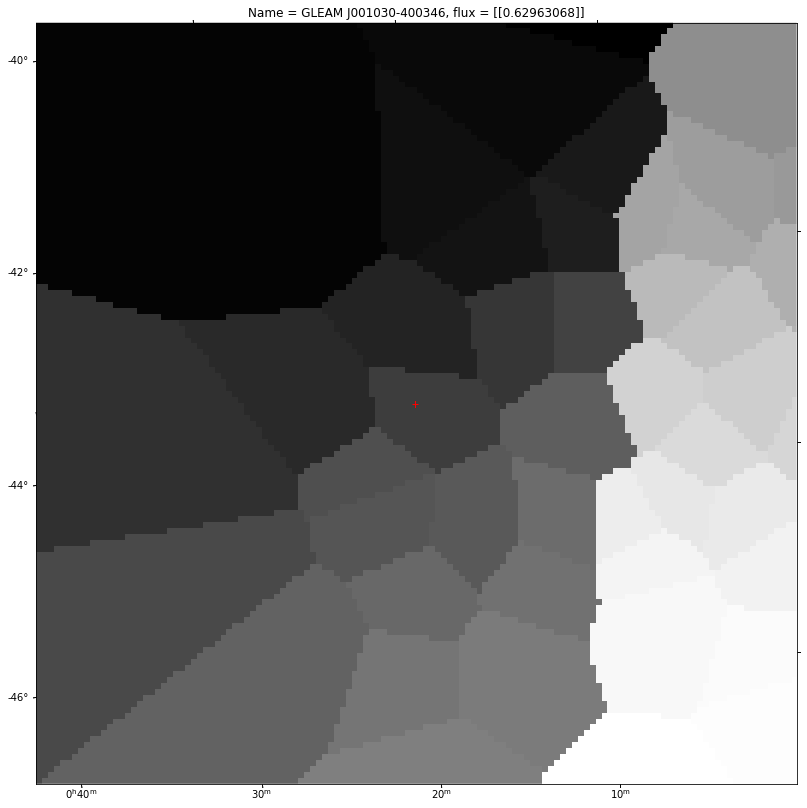

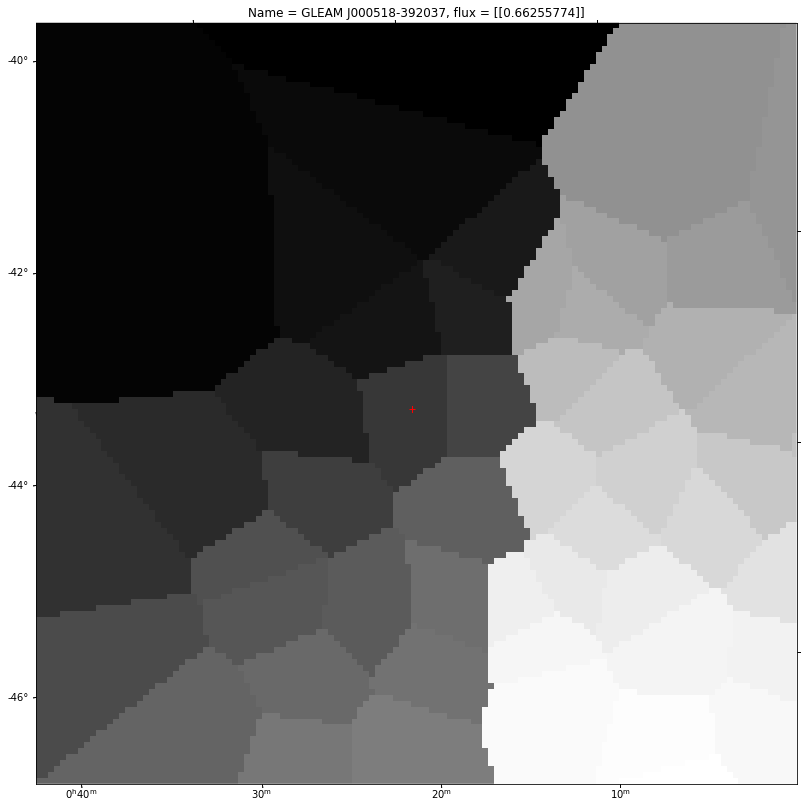

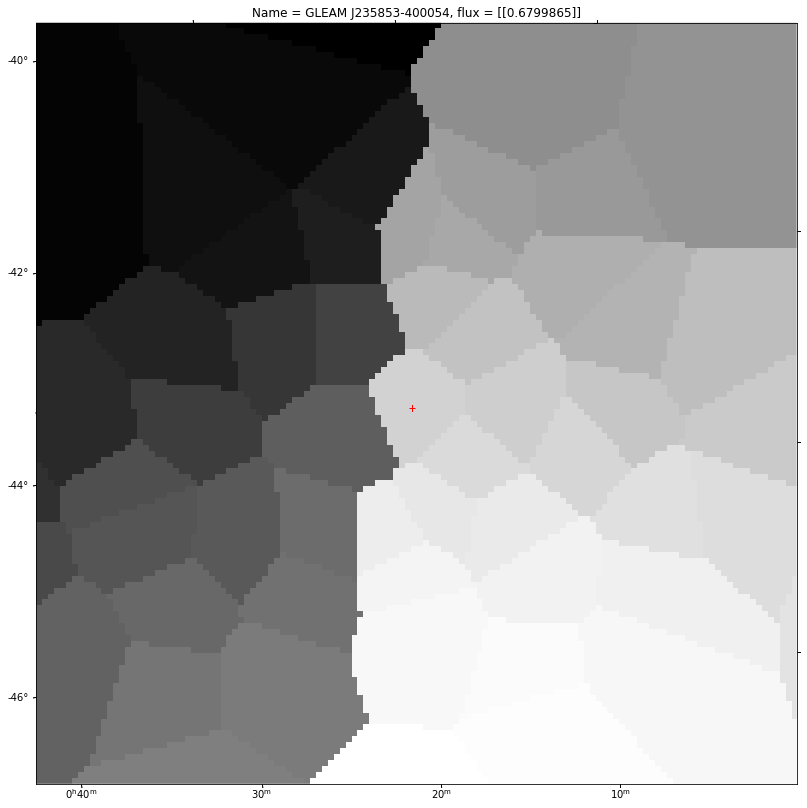

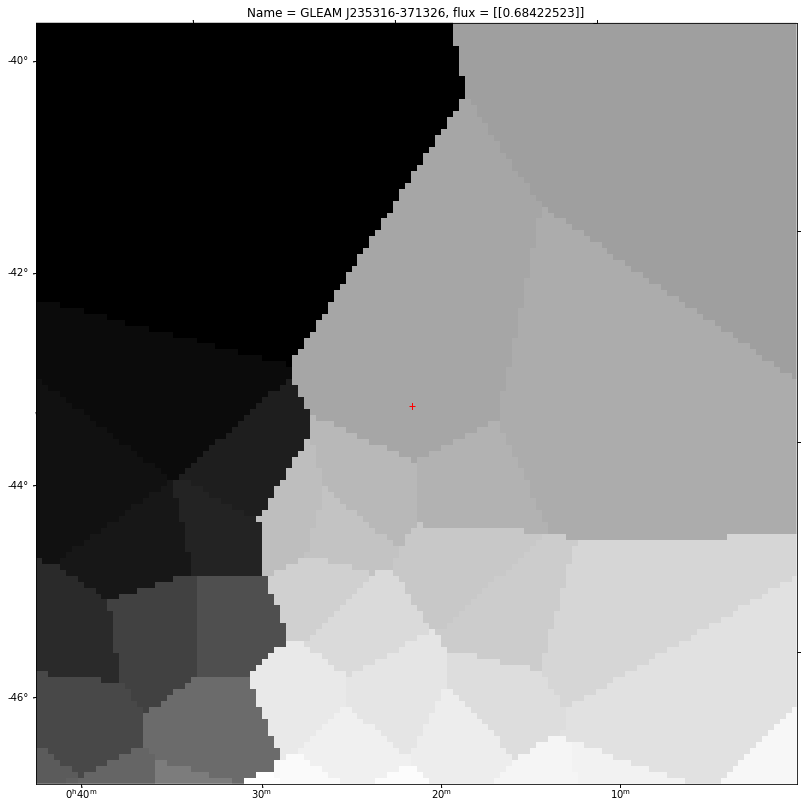

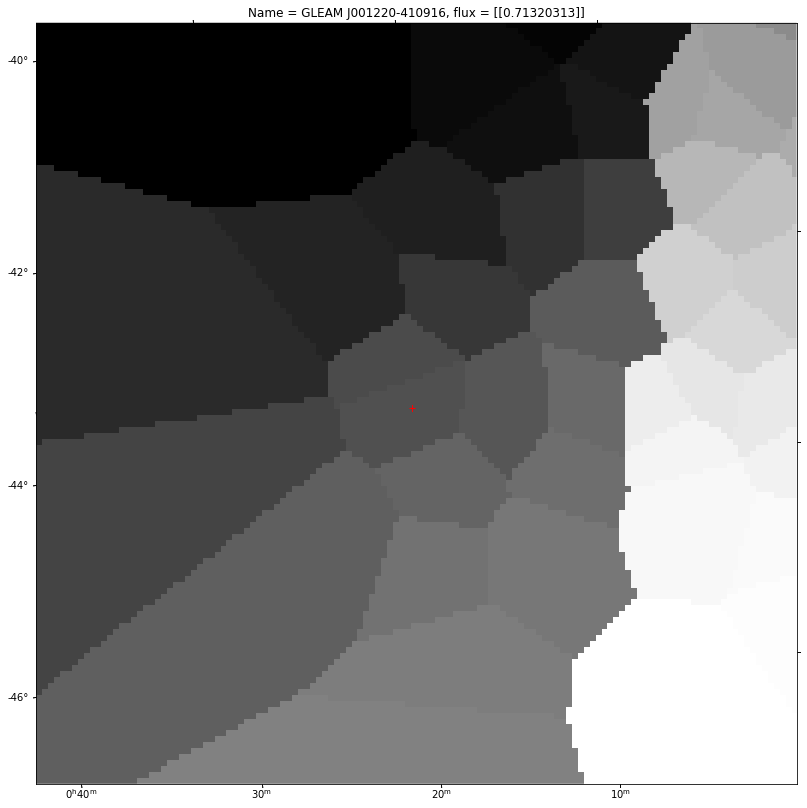

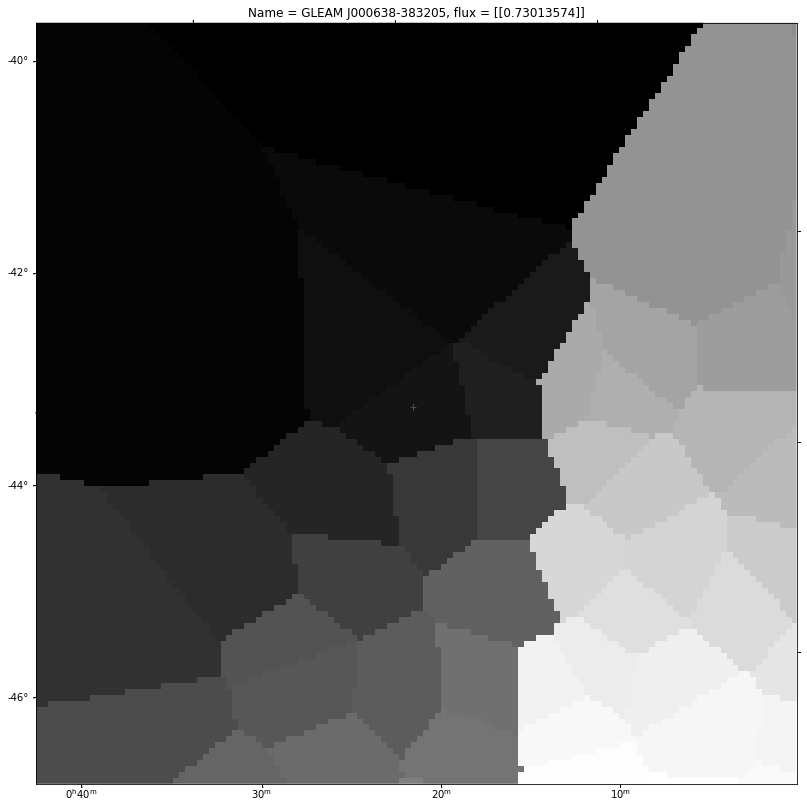

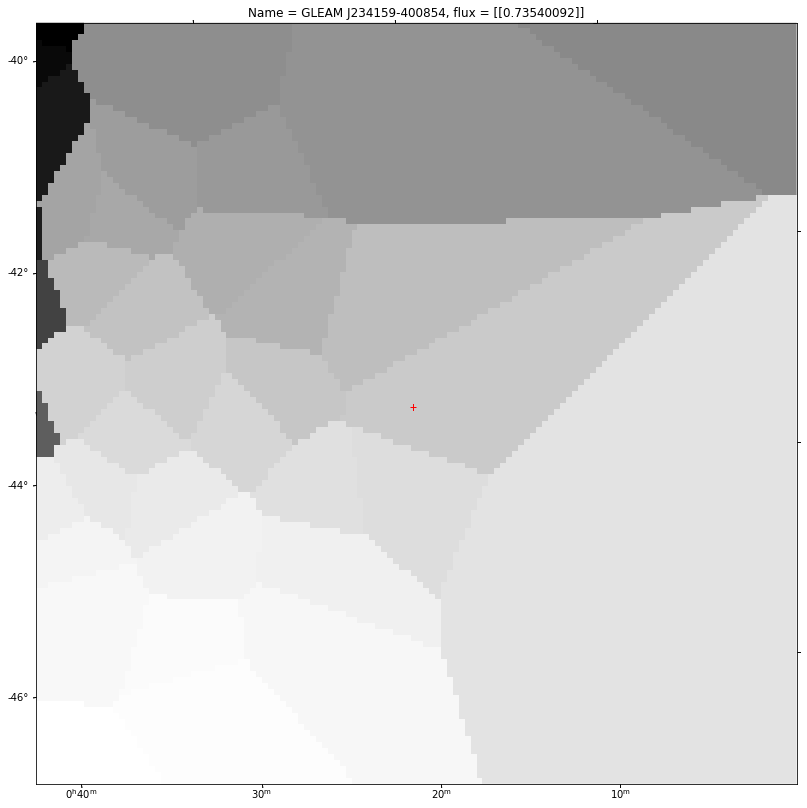

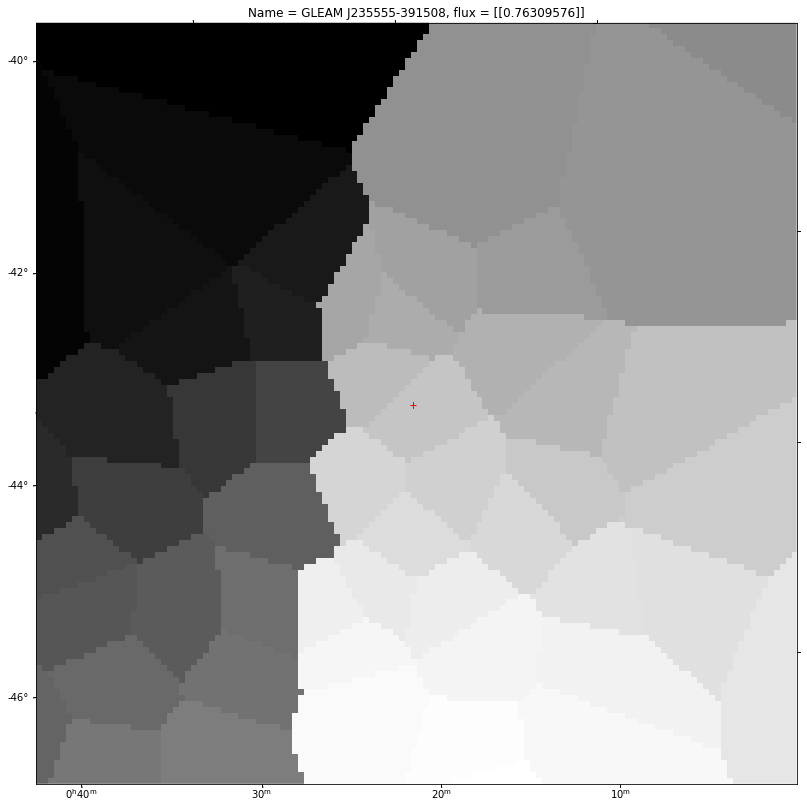

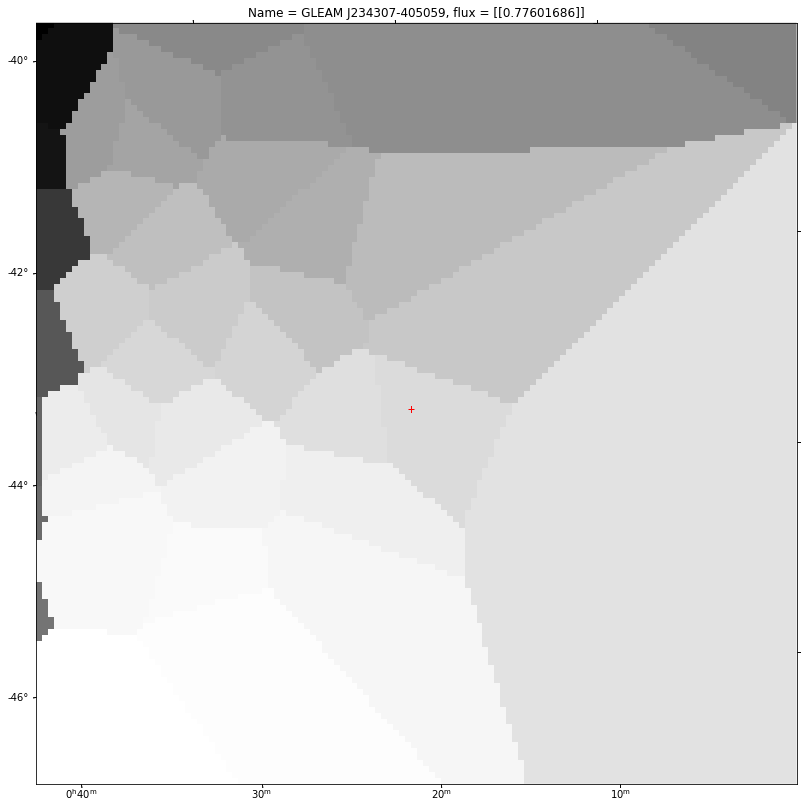

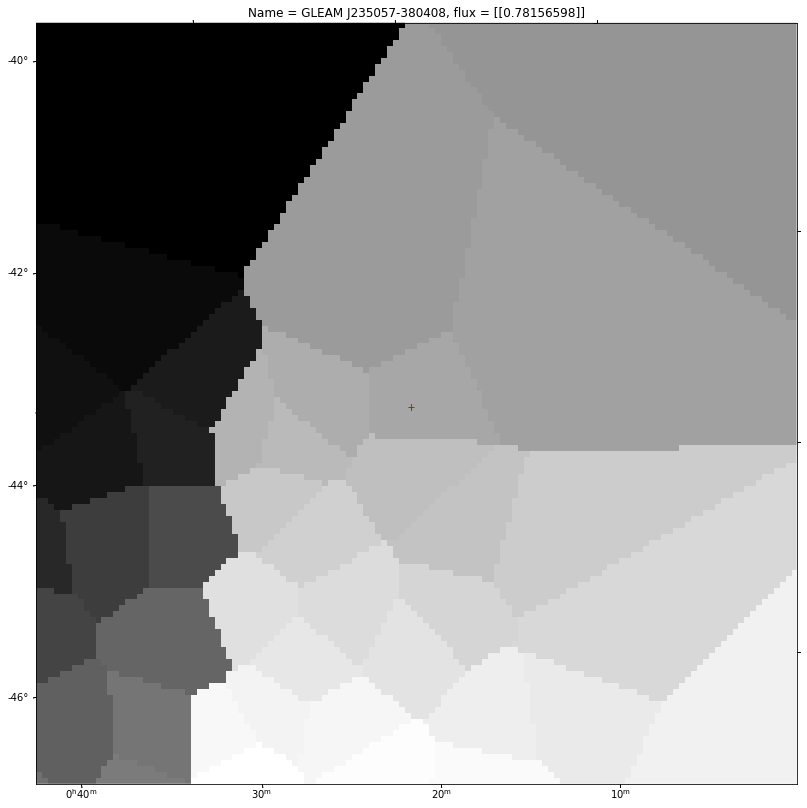

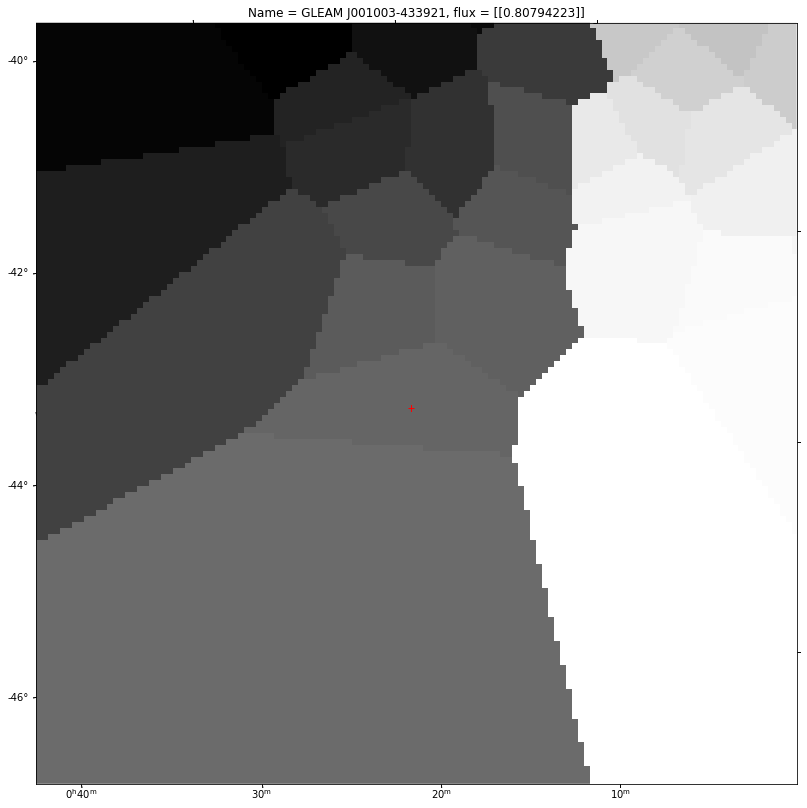

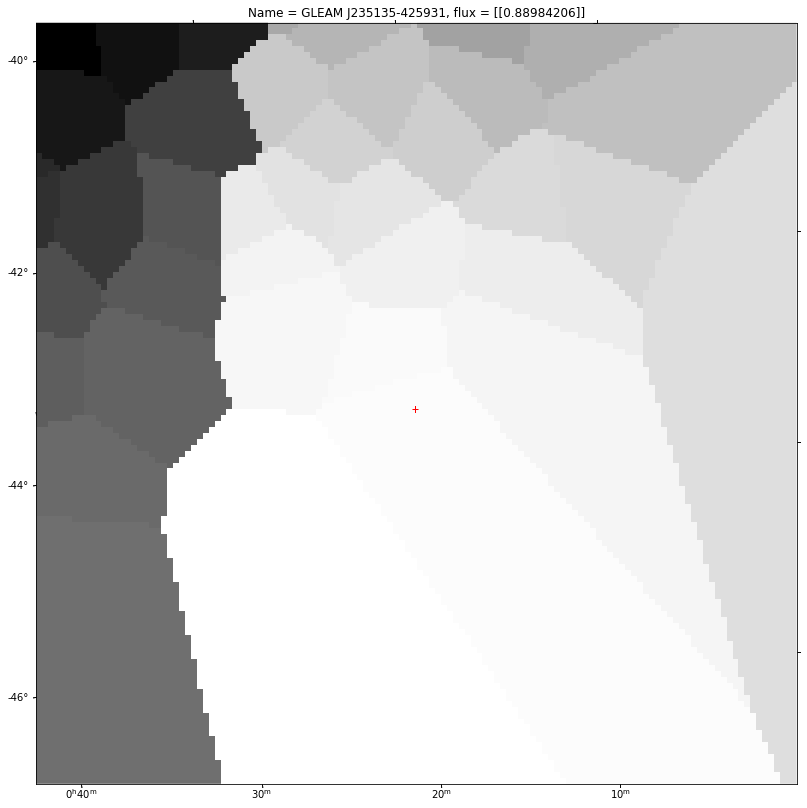

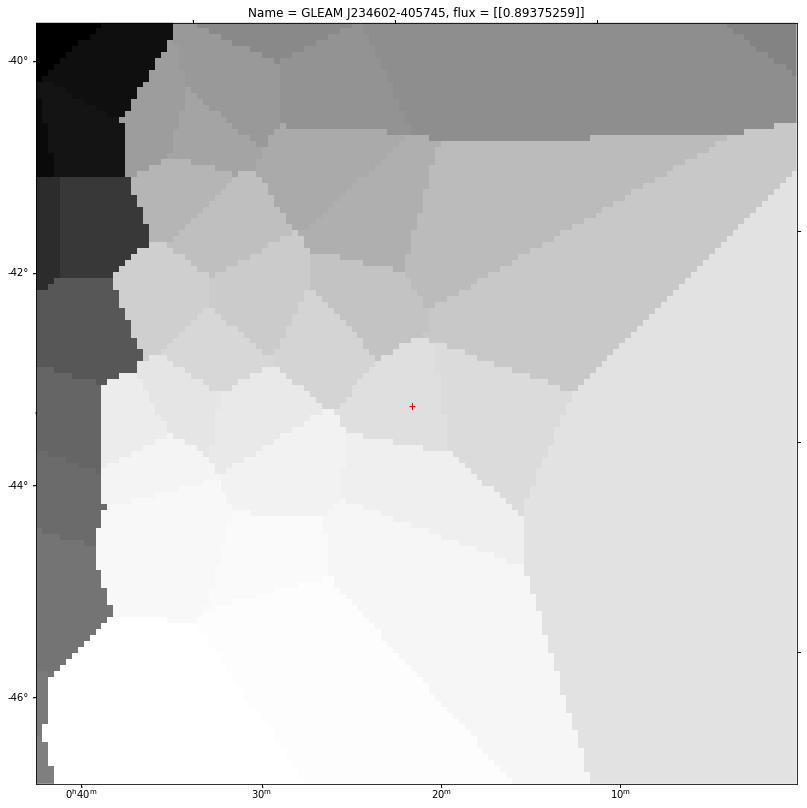

/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


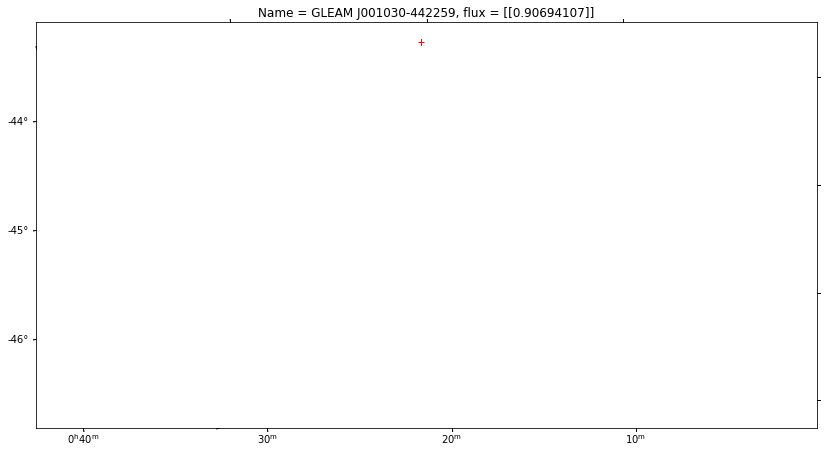

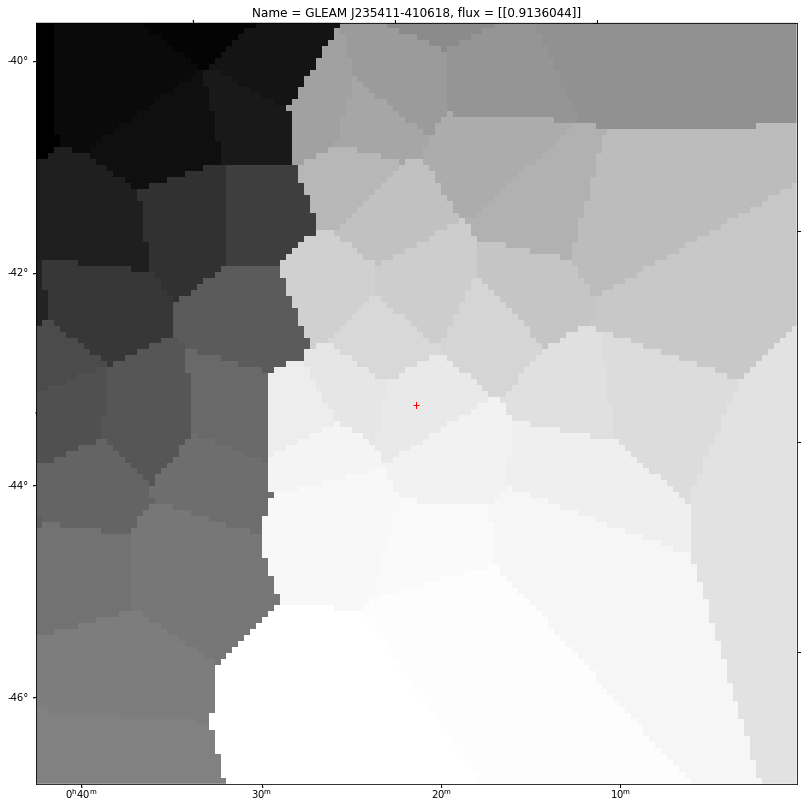

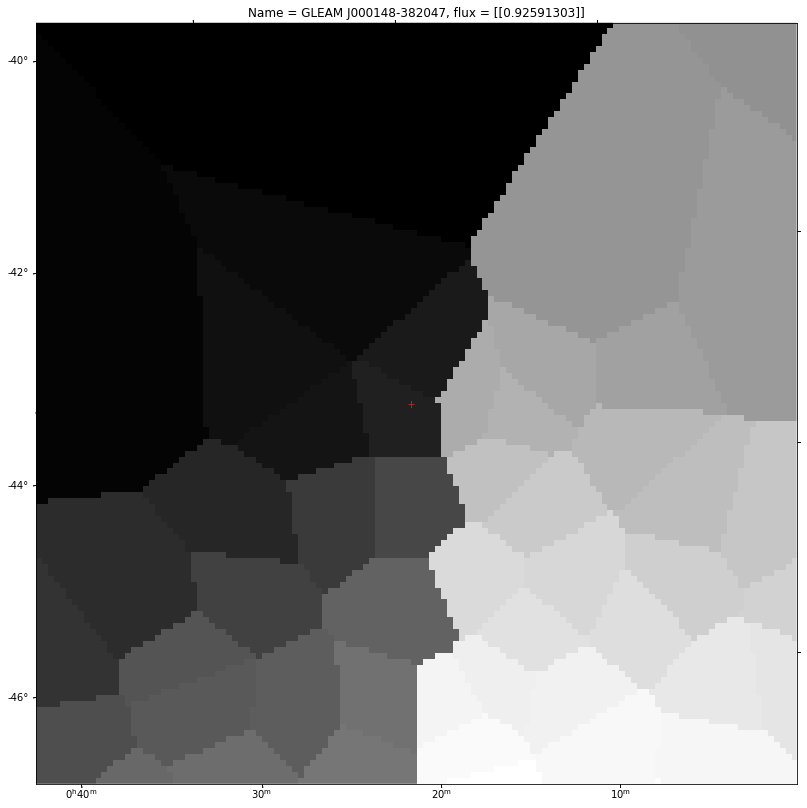

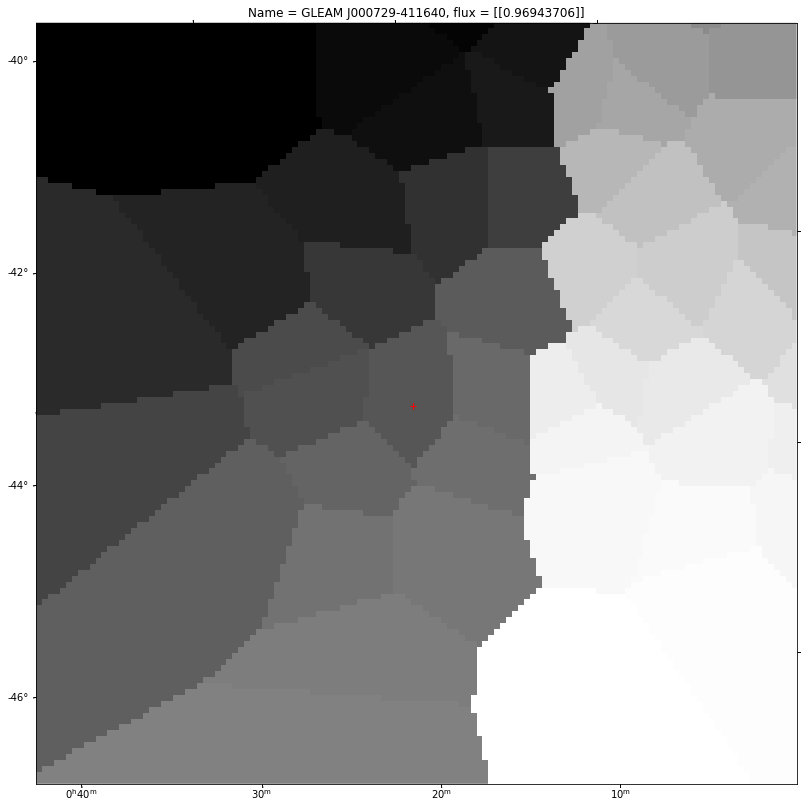

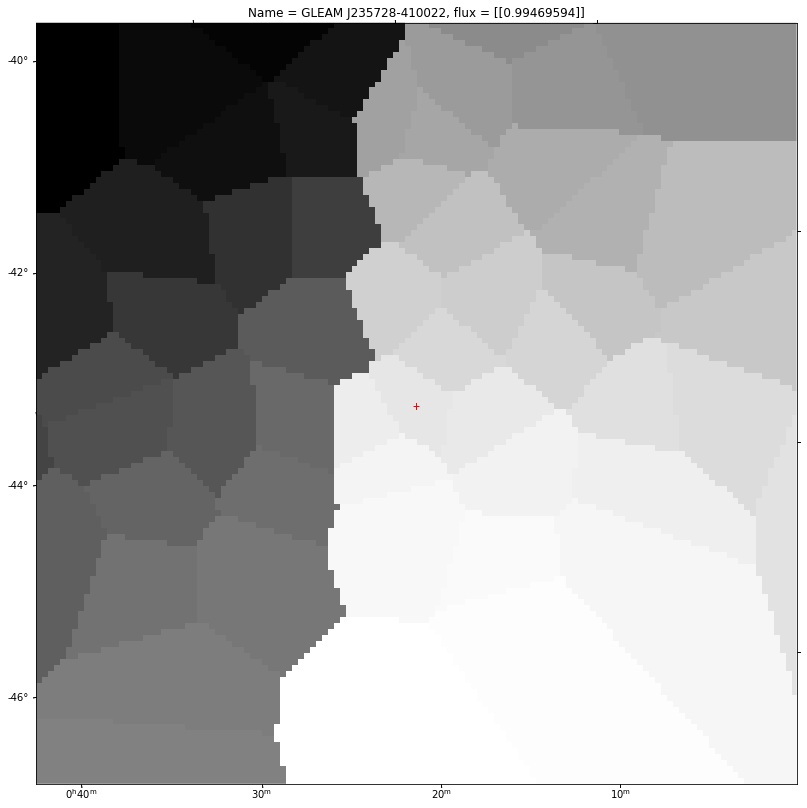

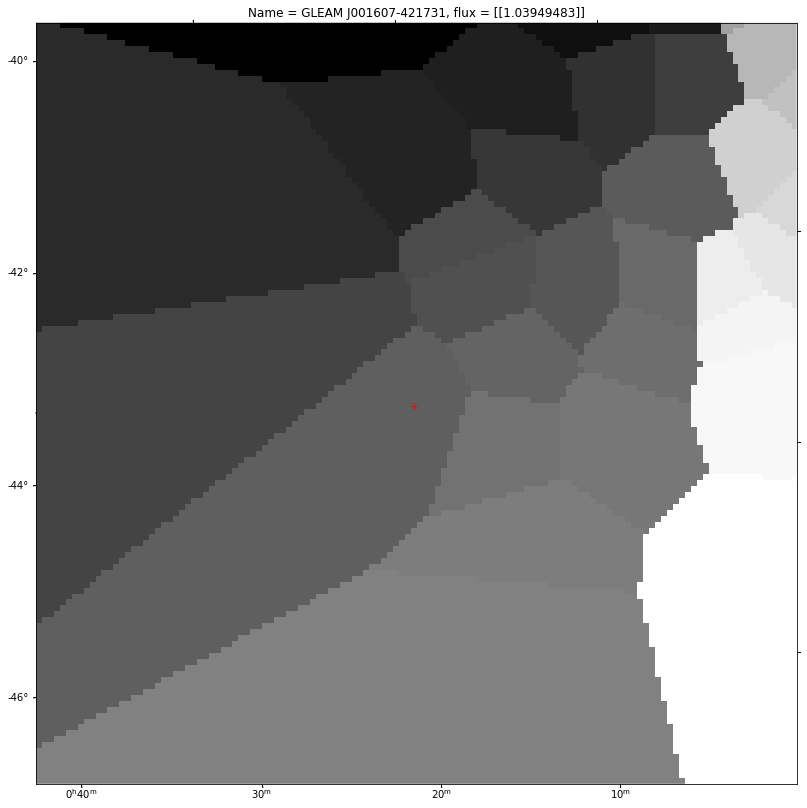

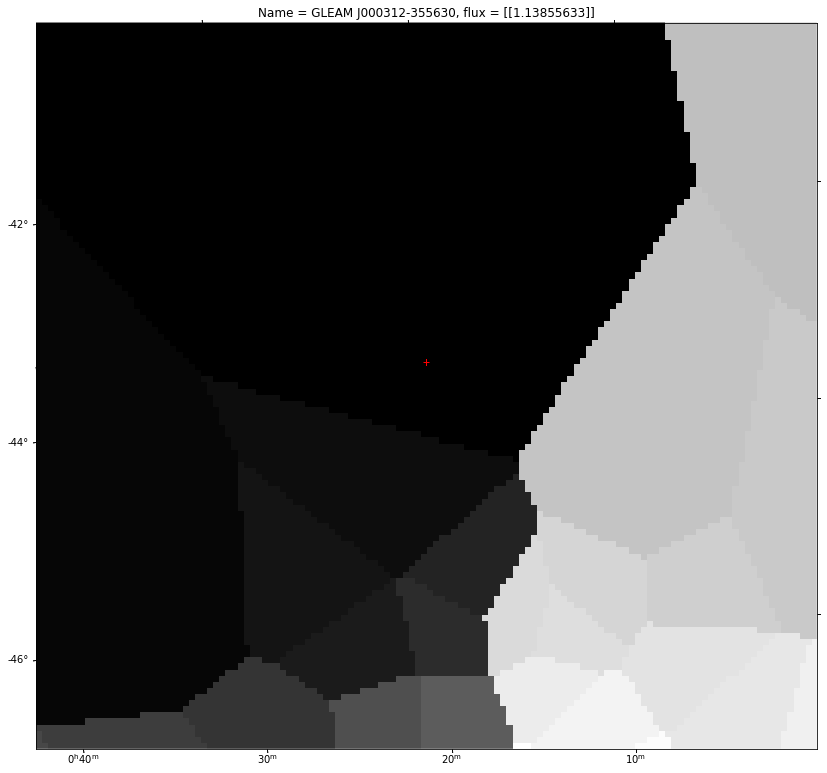

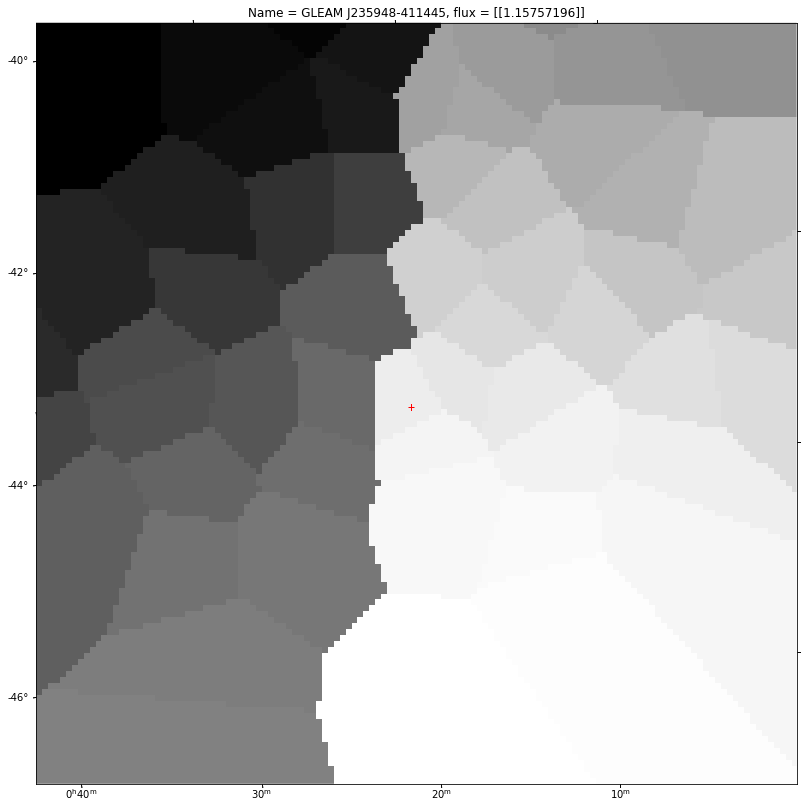

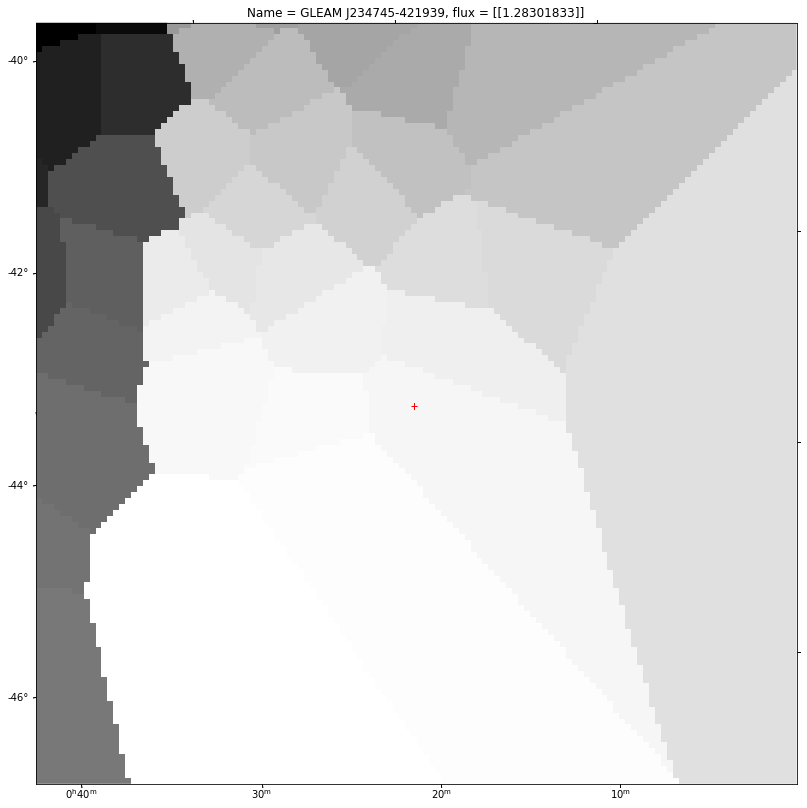

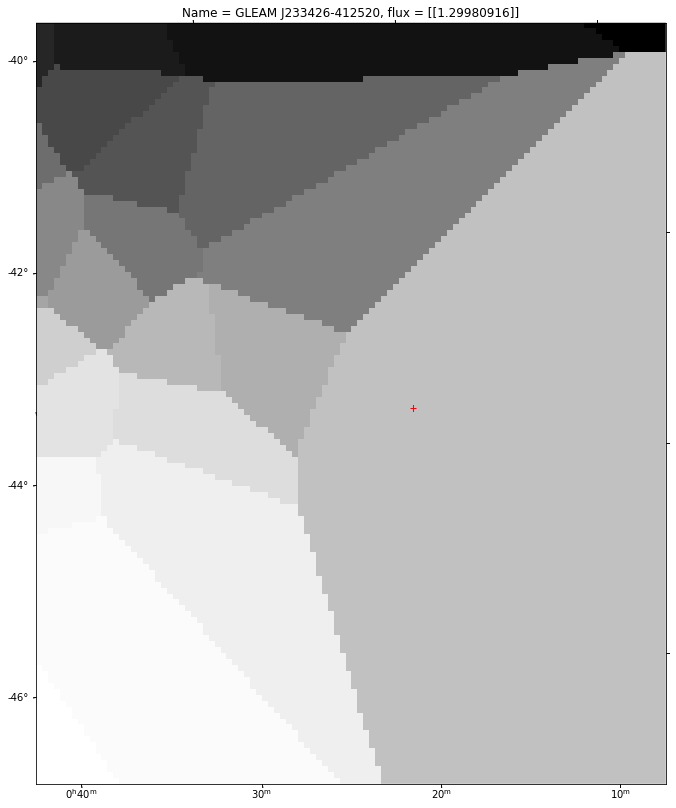

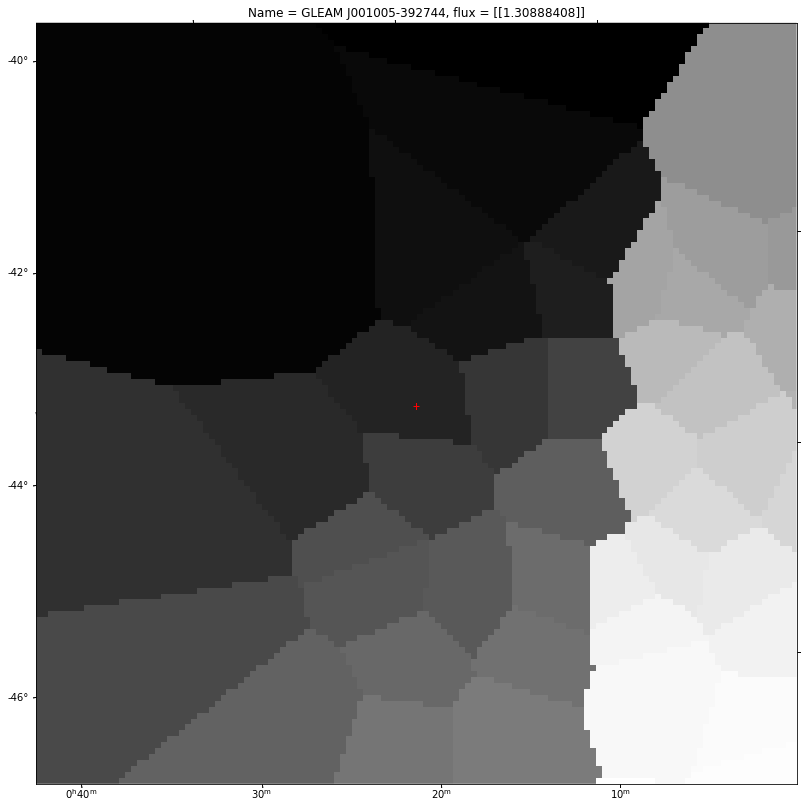

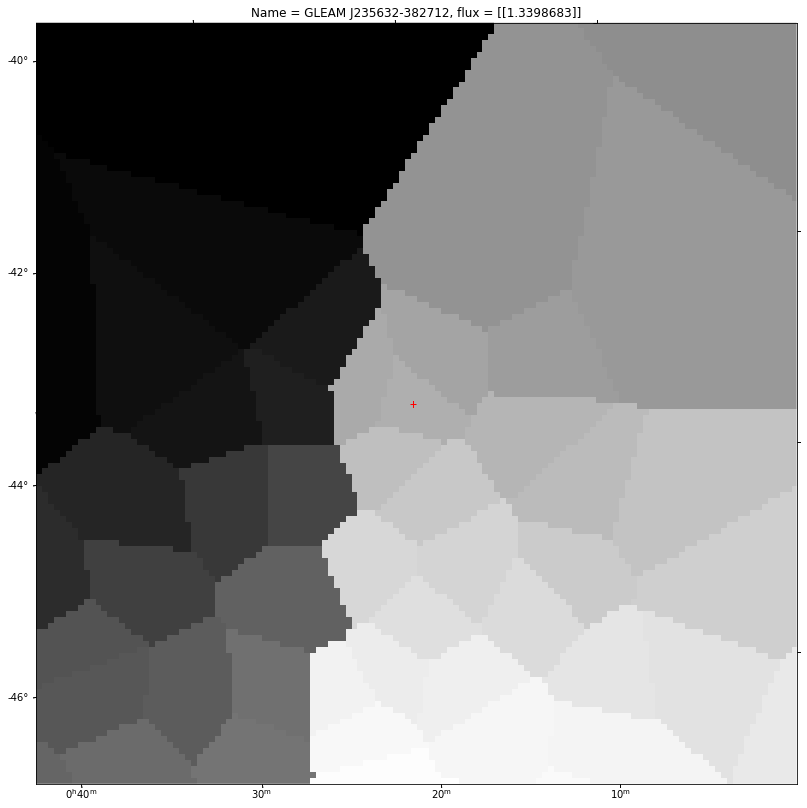

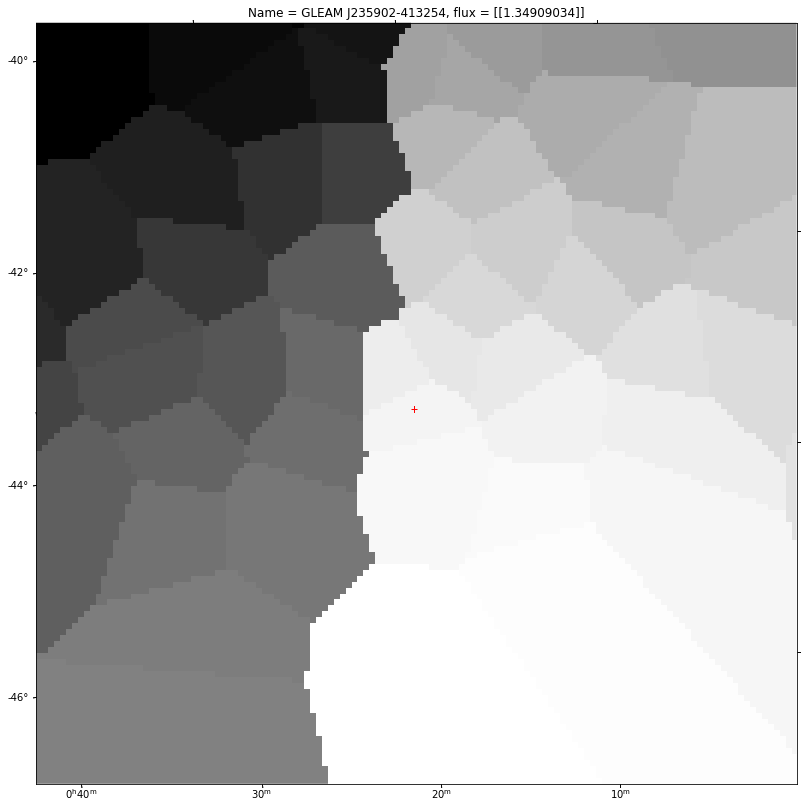

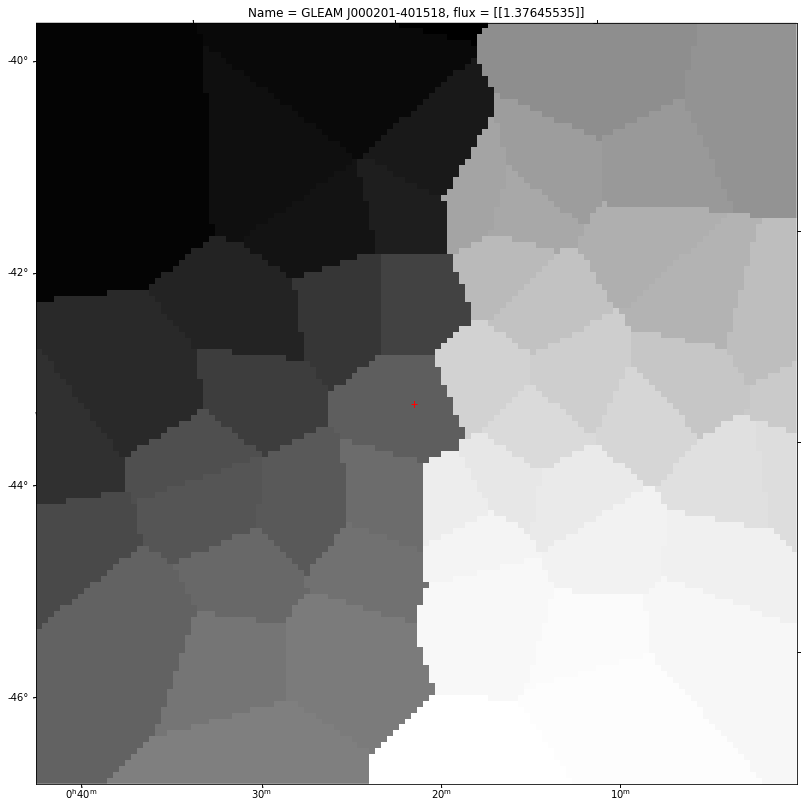

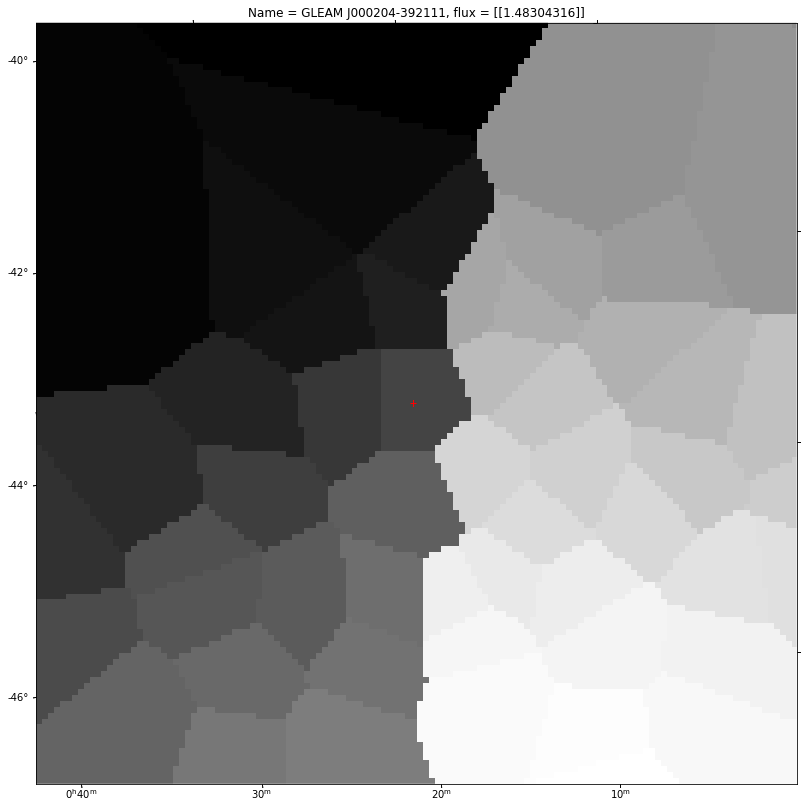

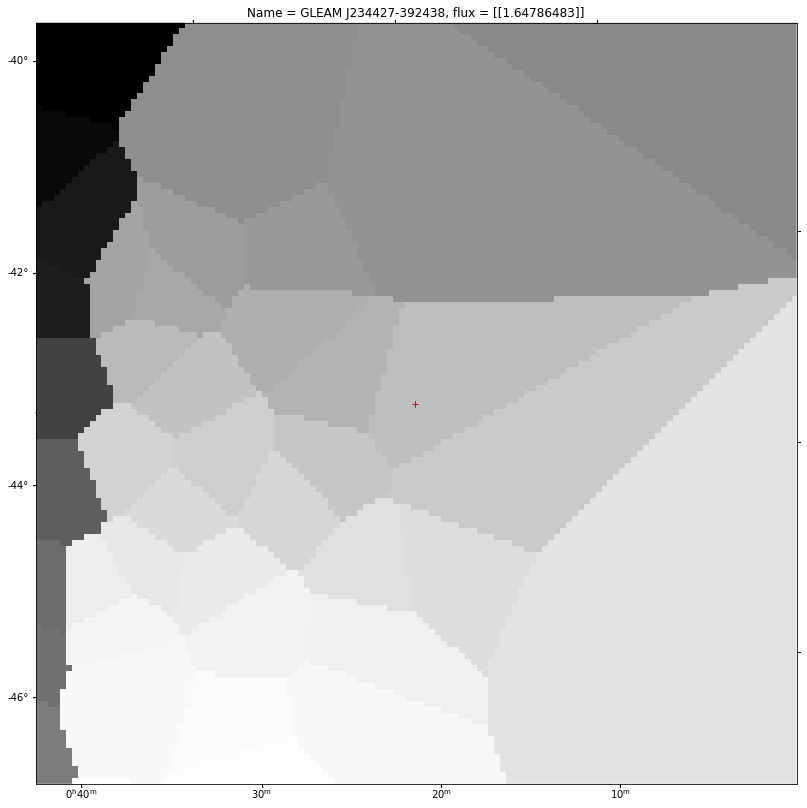

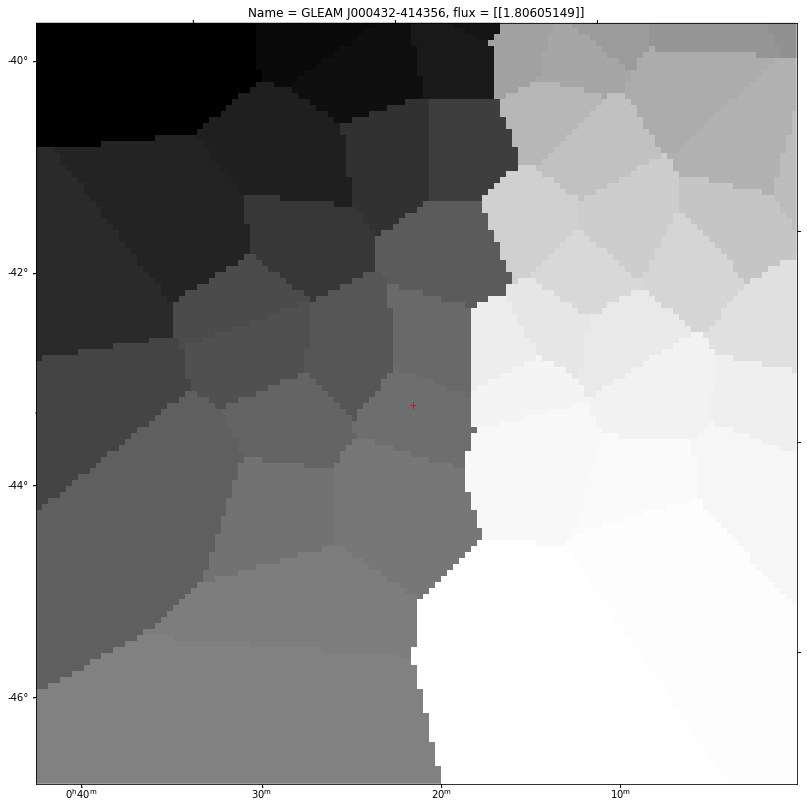

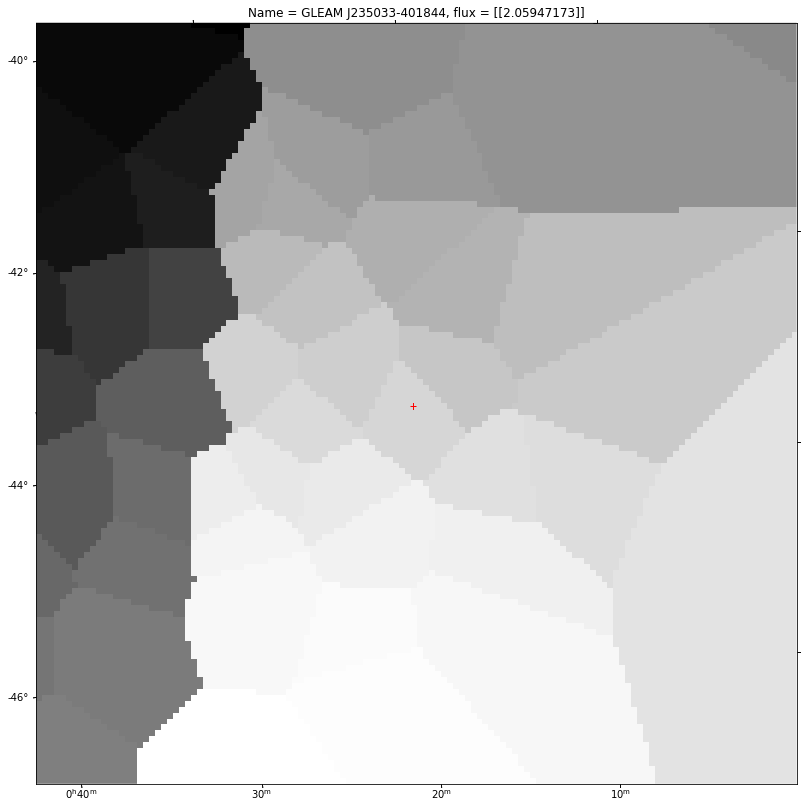

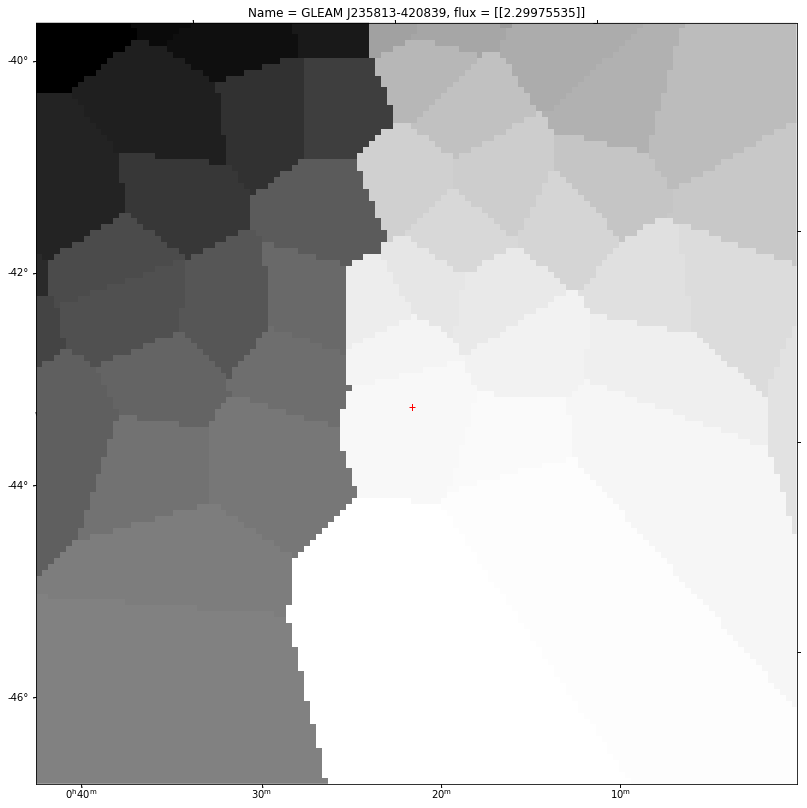

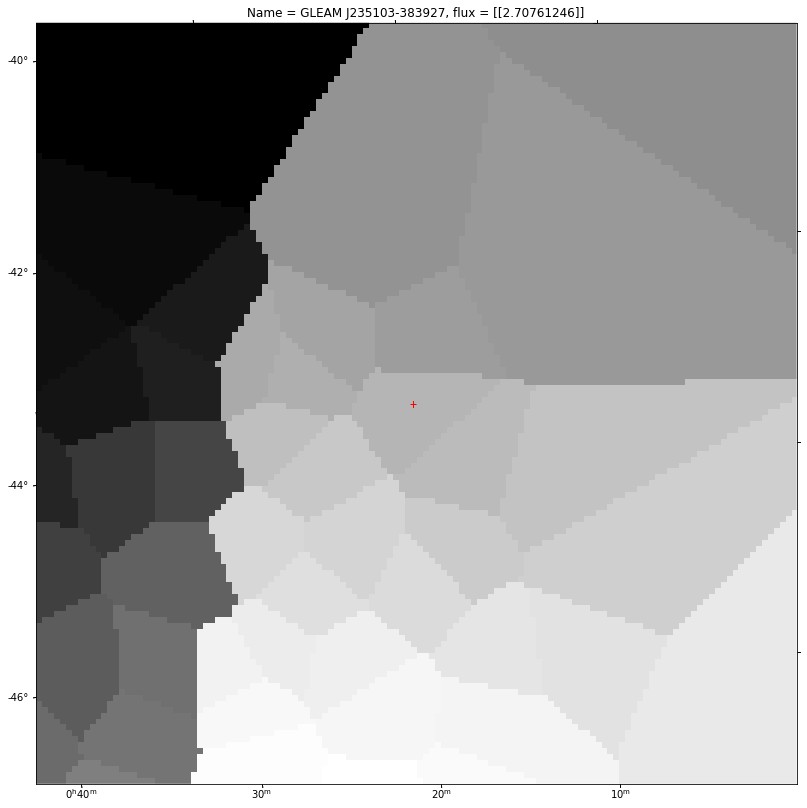

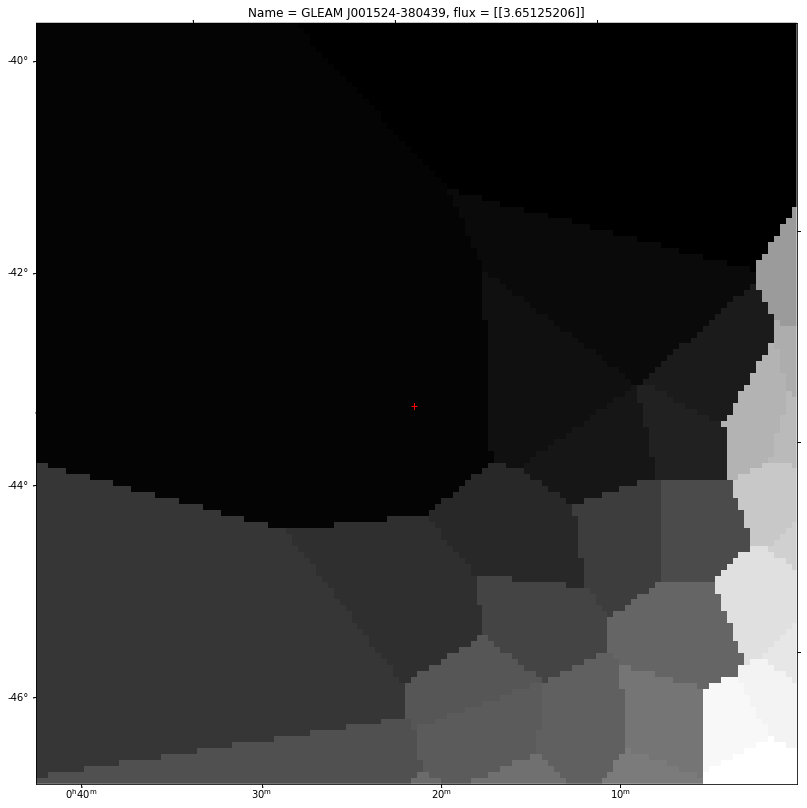

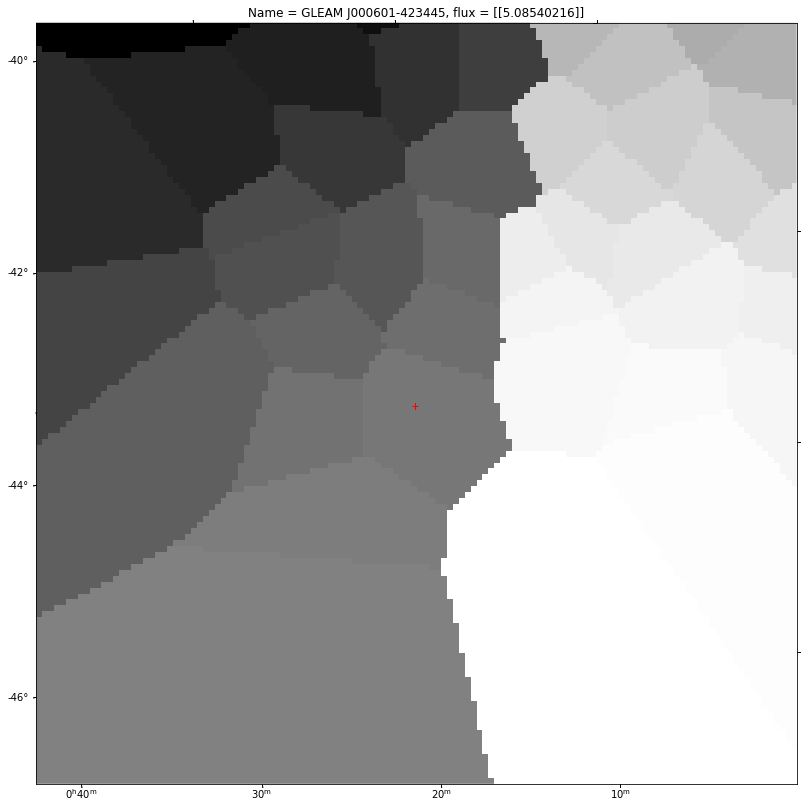

In [11]:
def max_flux(elem):
    return numpy.max(elem.flux)
sorted_filtered_bright_components=sorted(filtered_bright_components, key=max_flux)
show_components(vor_image, sorted_filtered_bright_components)